# 0.0 IMPORTS

## packages

In [1]:
import os, pickle, datetime
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as ss
import sweetviz as sv
import matplotlib.gridspec as gridspec
import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.model_selection            import train_test_split
from sklearn.preprocessing              import RobustScaler,MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.base                       import BaseEstimator, TransformerMixin
from IPython.display                    import Image
from sklearn.ensemble                   import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna.integration.lightgbm as lgb


pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

p:\Anaconda3\envs\insurance_cross\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'p:\\Python\\GitHub\\insurance_cross'

In [2]:
import lightgbm as lgb
import optuna

## helper classes

## helper funcions 

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 16]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## data import

In [5]:
df0=pd.read_csv(r"data/train.csv")
test=pd.read_csv(r"data/test.csv")
df0.head(1)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.00000,0,> 2 Years,Yes,40454.00000,26.00000,217,1


# split

In [6]:
X=df0.drop('Response',axis=1)
y=df0['Response']

Xtrain, Xtest0, ytrain, ytest0 = train_test_split(X,y, random_state=42,  test_size=0.40, stratify=y)

df0_train=pd.concat([Xtrain,ytrain],axis=1)

holdout=pd.concat([Xtest0,ytest0],axis=1)
holdout.to_csv(r"data/holdout.csv")


df0_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
215726,215727,Male,49,1,41.00000,0,1-2 Year,Yes,30123.00000,124.00000,109,0
244933,244934,Female,64,1,8.00000,0,1-2 Year,Yes,40700.00000,124.00000,241,0
189344,189345,Female,24,1,11.00000,1,< 1 Year,No,2630.00000,152.00000,120,0
232120,232121,Female,43,1,17.00000,1,1-2 Year,No,2630.00000,152.00000,159,0
304224,304225,Female,29,1,10.00000,1,< 1 Year,No,2630.00000,152.00000,117,0


# metadata

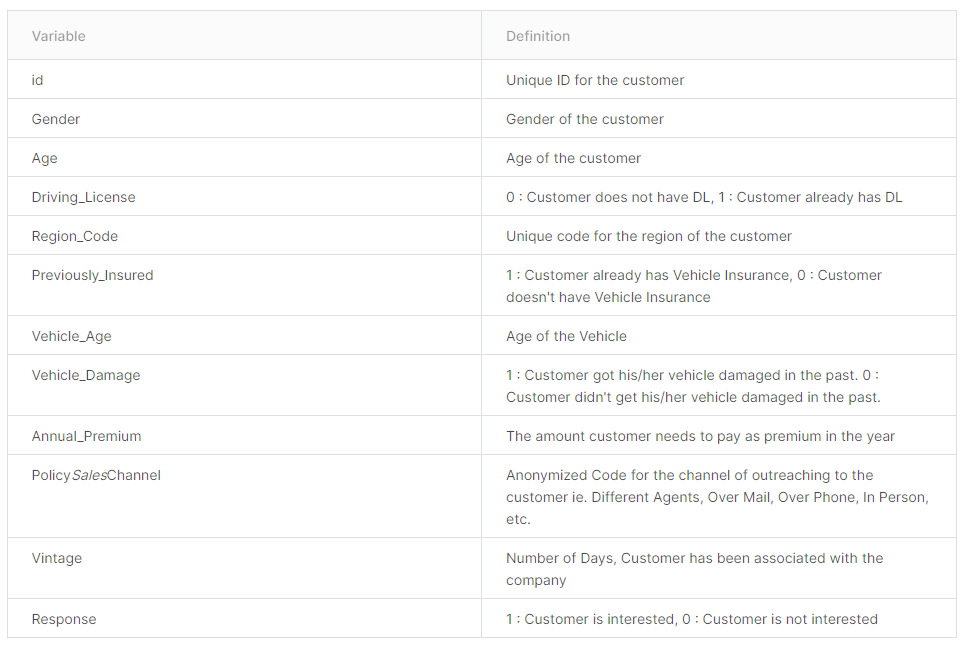

In [7]:
Image('img/metadata.png')

# 1.0 DATA DESCRIPTION

## 1.1 rename columns

In [90]:
df1=df0_train.copy()
df1.columns=df1.columns.str.lower()
df1.head(1)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,Male,49,1,41.00000,0,1-2 Year,Yes,30123.00000,124.00000,109,0


## 1.2 data dimensions

In [91]:
df1.shape

(228665, 12)

## 1.3 data types

In [92]:
df1.dtypes.sort_values()

id                        int64
age                       int64
driving_license           int64
previously_insured        int64
vintage                   int64
response                  int64
region_code             float64
annual_premium          float64
policy_sales_channel    float64
gender                   object
vehicle_age              object
vehicle_damage           object
dtype: object

In [94]:
#convert categoric features (region_code, policy_sales_channel) to object:
class data_cleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X2=X.copy()
        for i in ['region_code','policy_sales_channel']:
            X[i]=X[i].astype('object')    
        return X2


cleaner=data_cleaning().fit(df1)

pickle.dump(cleaner, open( r'parameters\data_cleaning.pkl', 'wb') )


In [89]:

for i in ['region_code','policy_sales_channel']:
    df1[i]=df1[i].astype('object')

TypeError: dump() missing required argument 'file' (pos 2)

## 1.4 check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 fillout NA

## 1.6 descriptive statistics for numeric attributes

In [13]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
id,190732.11463,190816.00000,110006.93804,2.00000,381109.00000,-0.00135,-1.19938
age,38.85382,36.00000,15.51915,20.00000,85.00000,0.66815,-0.57301
driving_license,0.99782,1.00000,0.04662,0.00000,1.00000,-21.35825,454.17881
previously_insured,0.45828,0.00000,0.49826,0.00000,1.00000,0.16748,-1.97197
annual_premium,30594.86624,31705.00000,17194.63877,2630.00000,508073.00000,1.49963,25.58896
vintage,154.44938,154.00000,83.65082,10.00000,299.00000,0.00234,-1.20027
response,0.12256,0.00000,0.32794,0.00000,1.00000,2.30191,3.29881


# 2.0 FEATURE ENGINEERING

## 2.1 hypotesis mapping

In [14]:
df2=df1.copy()

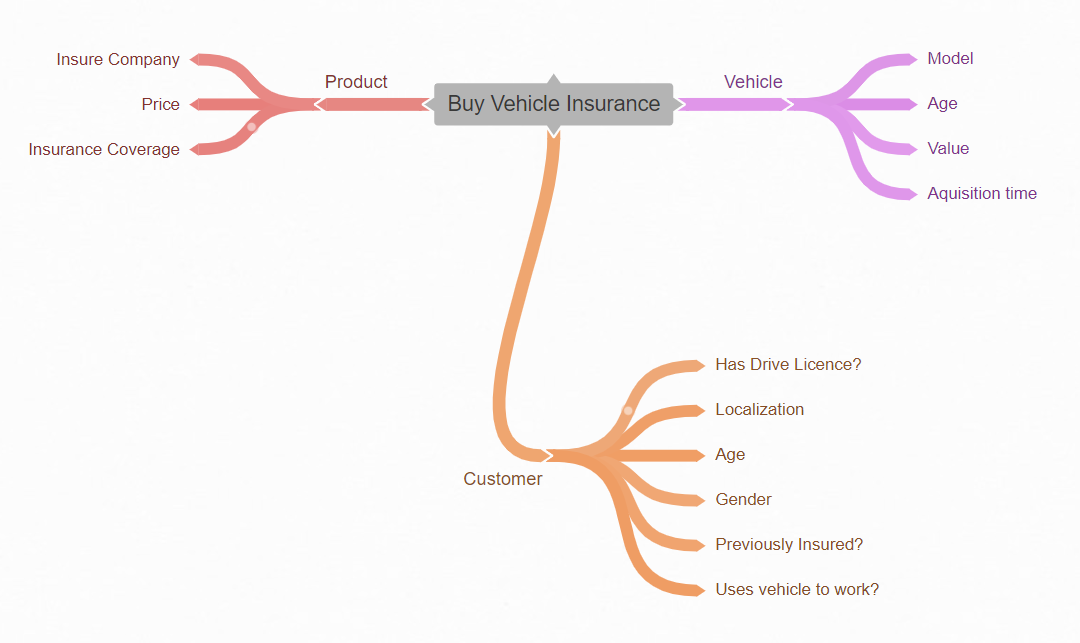

In [15]:
Image('img/mindmap.png')

## 2.2 hypoteses list

## 2.3 feature creation

## 2.4 rename object values: vehicle age

In [16]:
df2['vehicle_age'].unique()

array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object)

In [17]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X2=X.copy()
        X2.columns=X2.columns.str.lower()
        X2['vehicle_age']=X2['vehicle_age'].map({'> 2 Years':'2. 2_more_years','1-2 Year':'1. 1_2_years', '< 1 Year': '0. 1_less_years'})
        return X2

In [18]:
fe=FeatureEngineering().fit(df2)
df2=FeatureEngineering().transform(df2)
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,Male,49,1,41.00000,0,1. 1_2_years,Yes,30123.00000,124.00000,109,0
244933,244934,Female,64,1,8.00000,0,1. 1_2_years,Yes,40700.00000,124.00000,241,0
189344,189345,Female,24,1,11.00000,1,0. 1_less_years,No,2630.00000,152.00000,120,0
232120,232121,Female,43,1,17.00000,1,1. 1_2_years,No,2630.00000,152.00000,159,0
304224,304225,Female,29,1,10.00000,1,0. 1_less_years,No,2630.00000,152.00000,117,0


In [19]:
pickle.dump(FeatureEngineering(),open("parameters/feature_engineering.pkl","wb"))

# 3.0 FEATURE FILTERING

In [20]:
df3=df2.copy()

## 3.1 row filtering

## 3.2 cols filtering

# 4.0 EXPLORATORY DATA ANALYSIS

In [21]:
df4=df3.copy()

## 4.1 univariate analysis

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report descritive analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



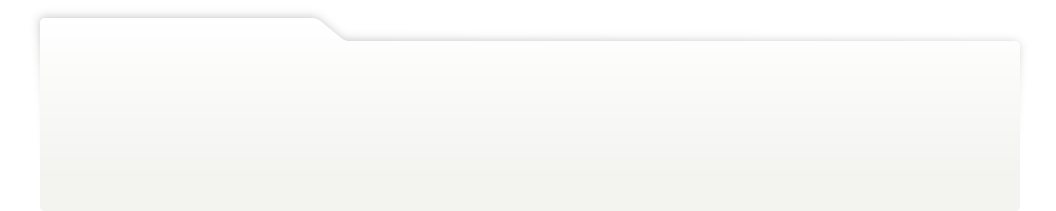
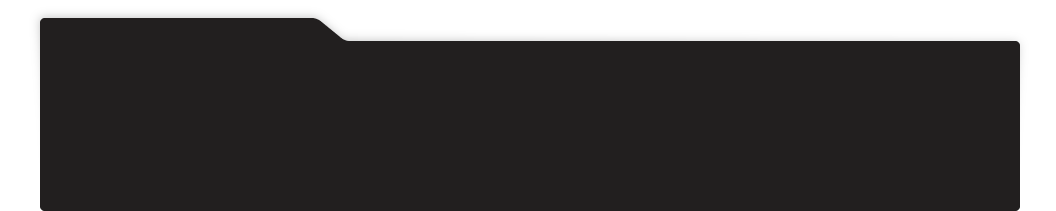
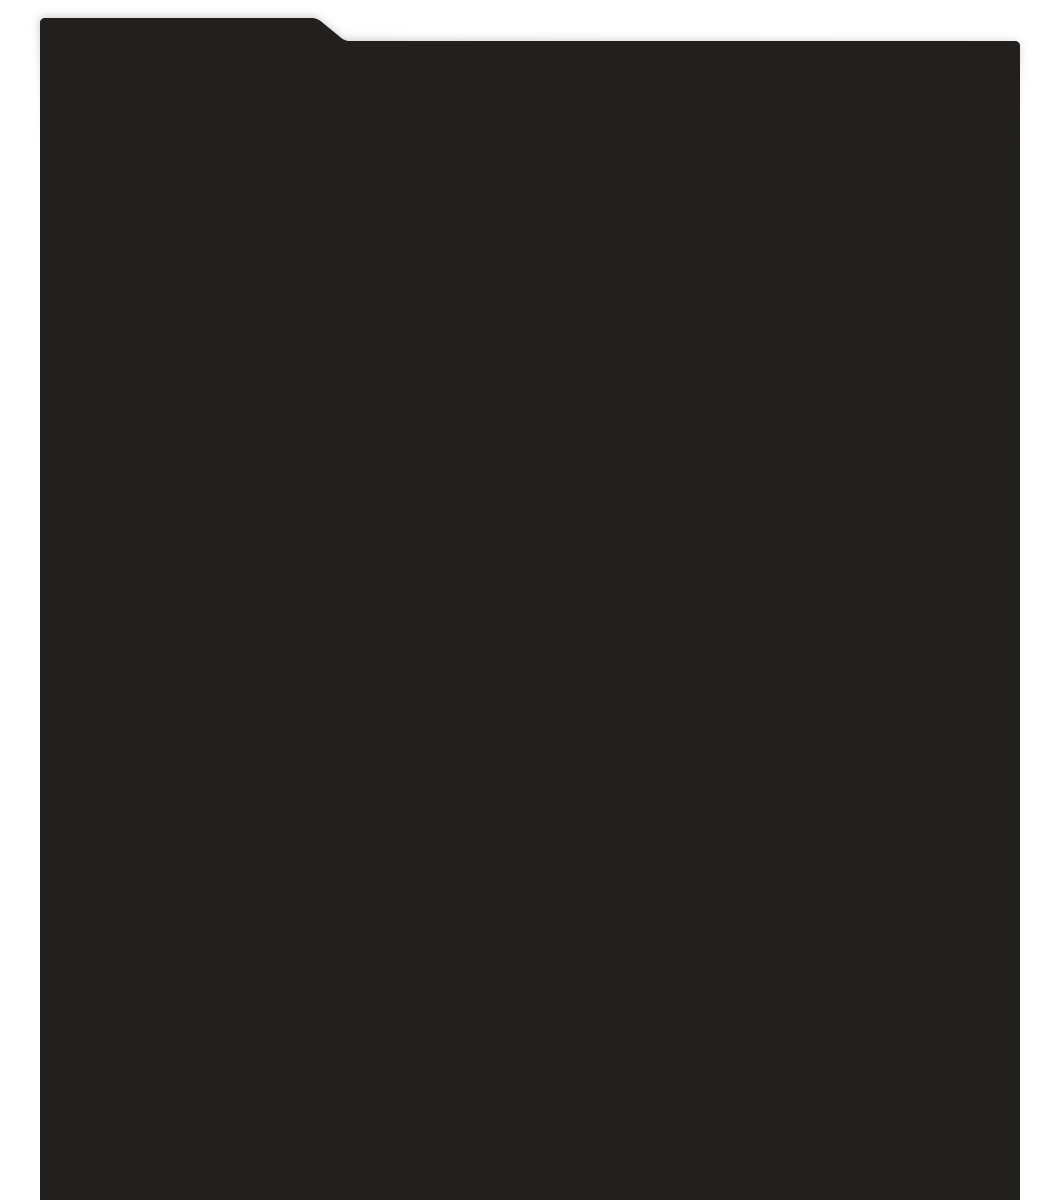
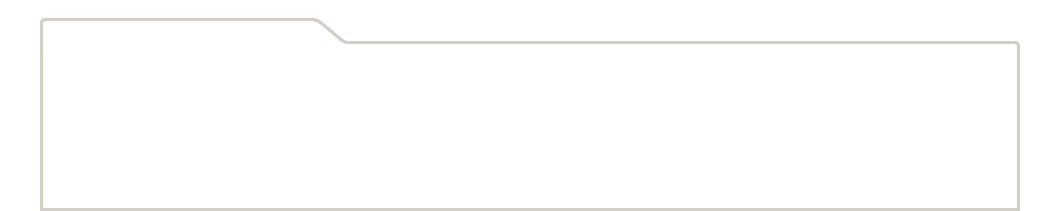
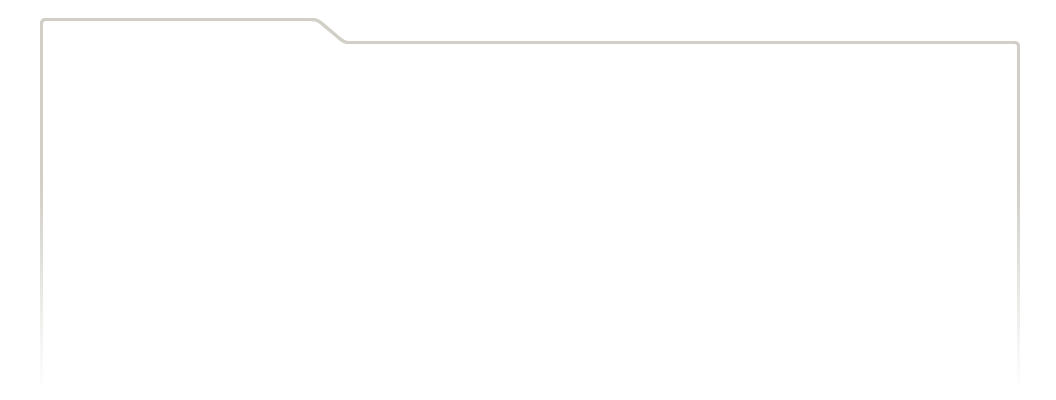
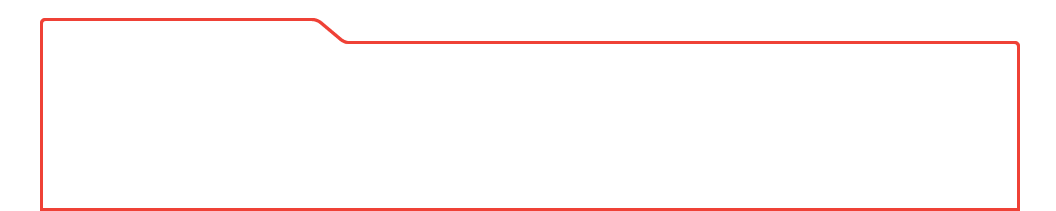
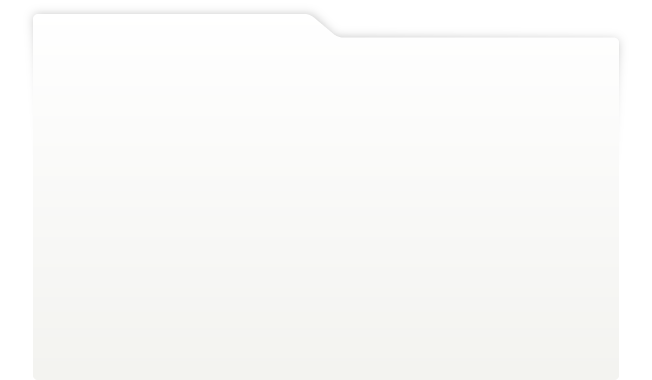
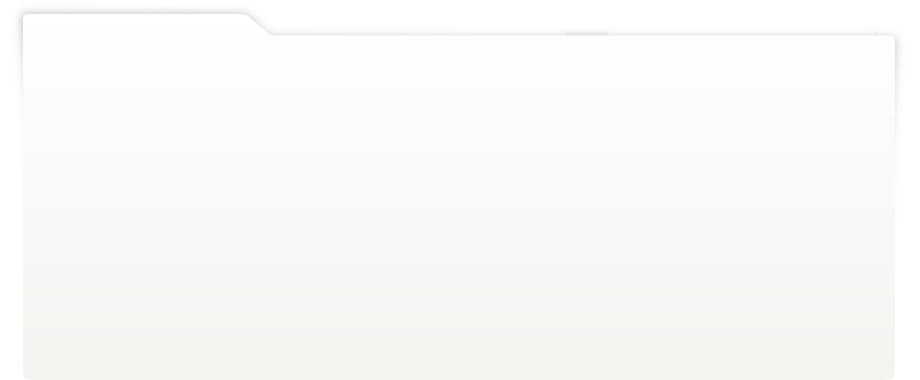
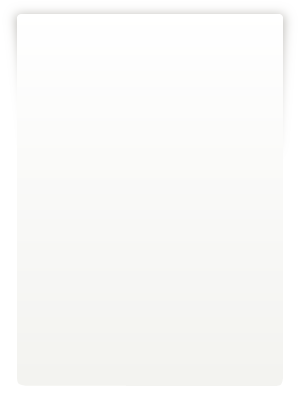
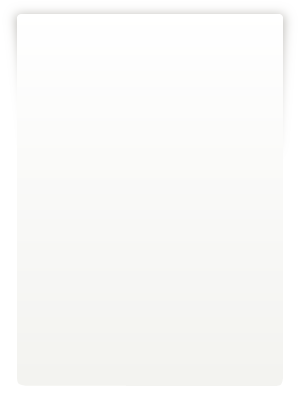
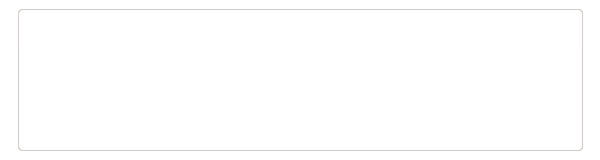
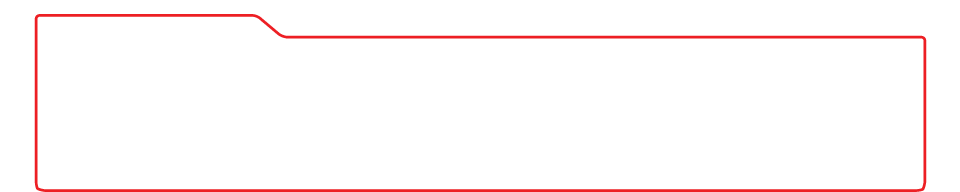
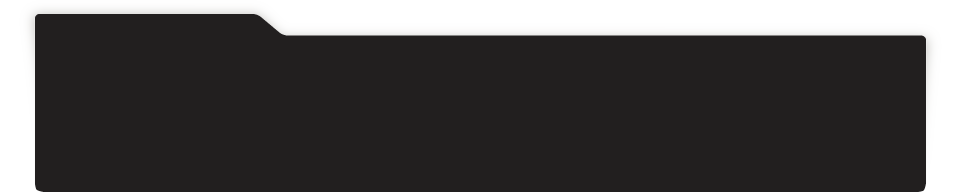
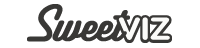
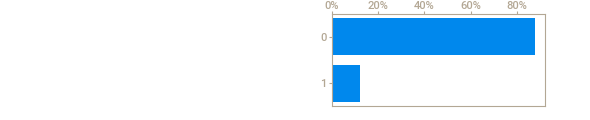
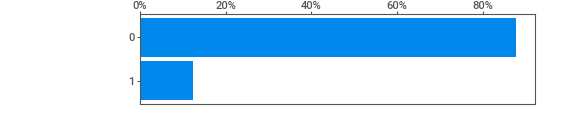
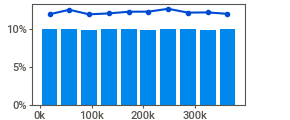
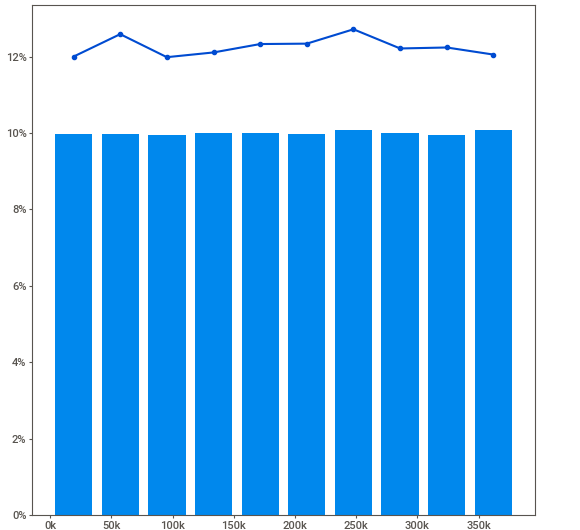
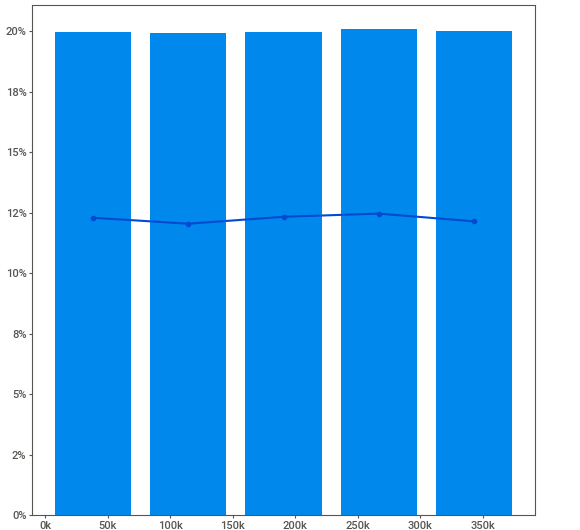
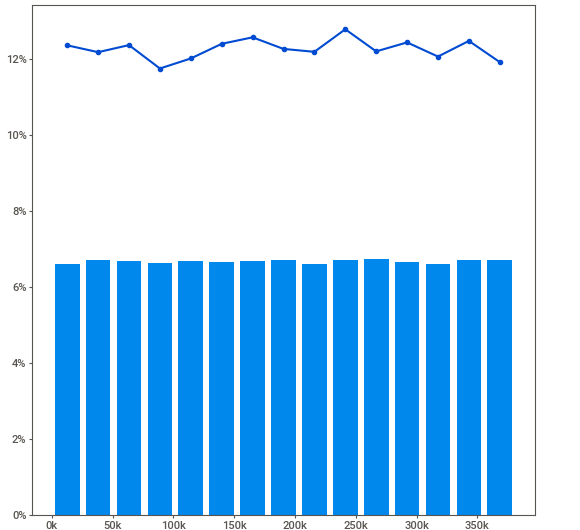
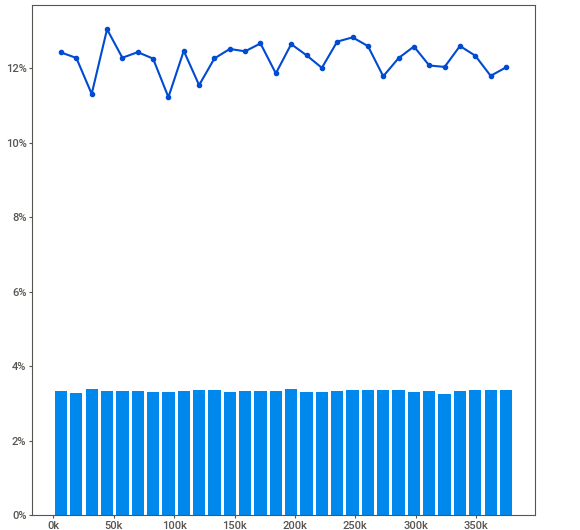
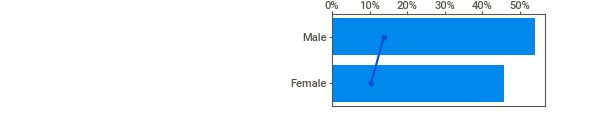
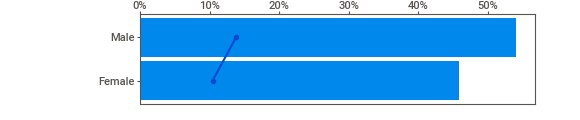
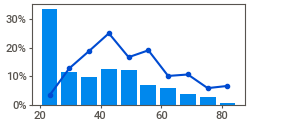
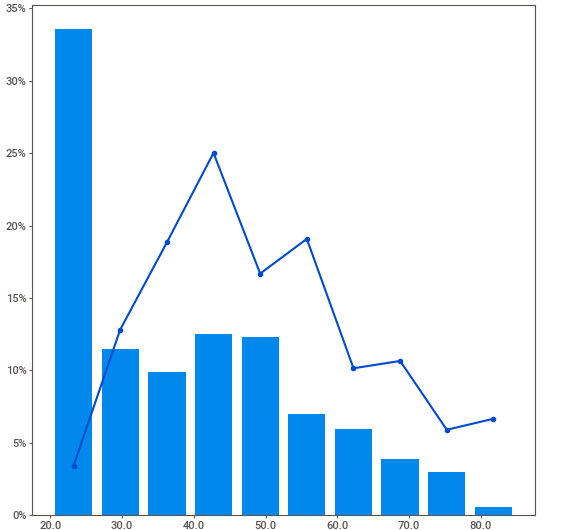
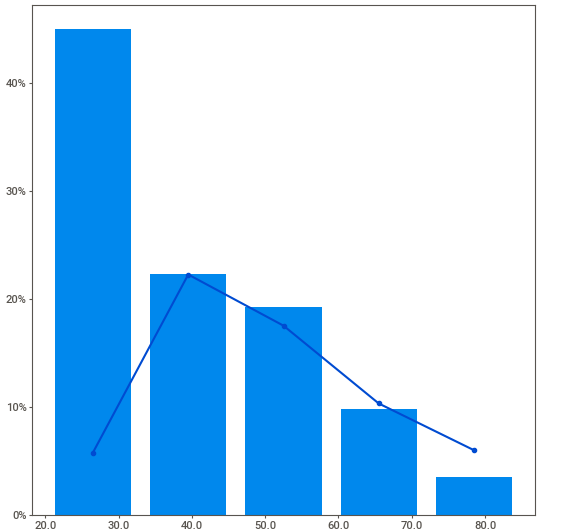
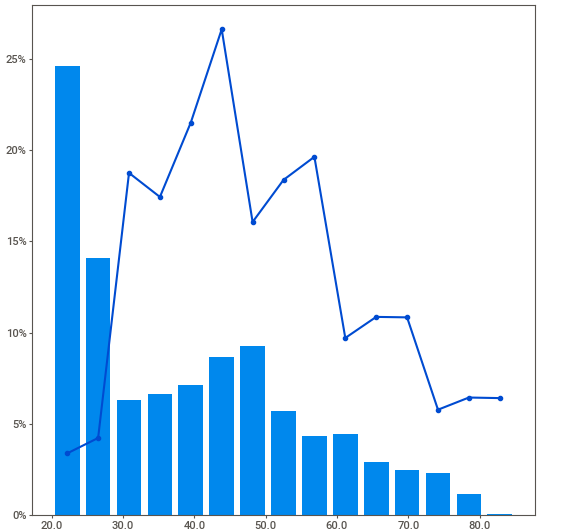
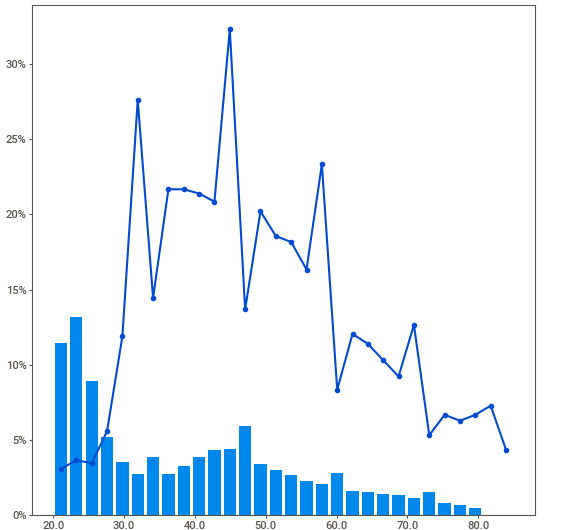
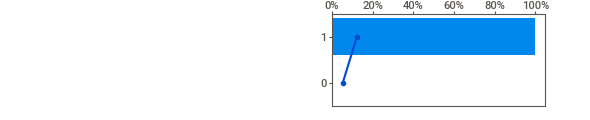
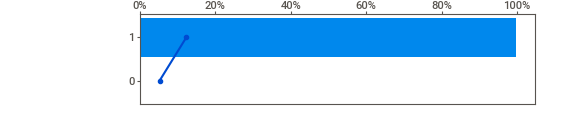
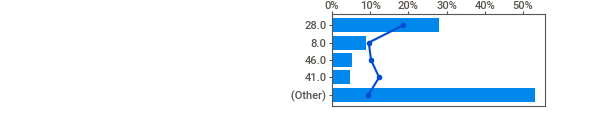
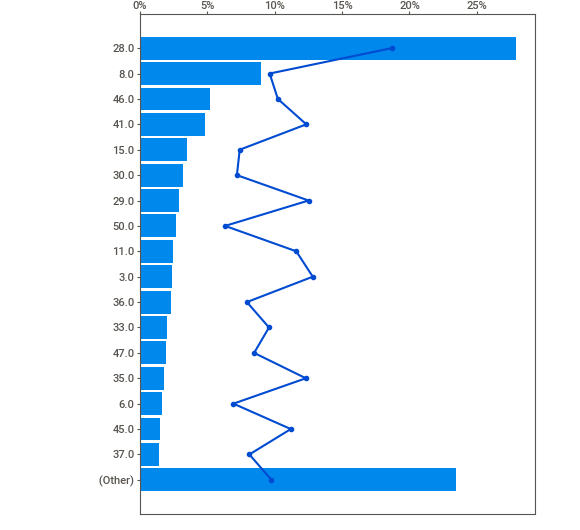
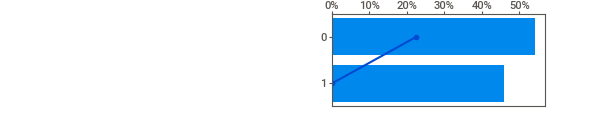
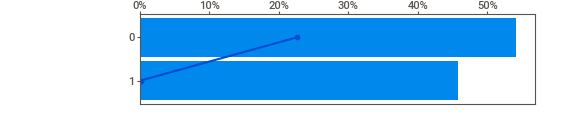
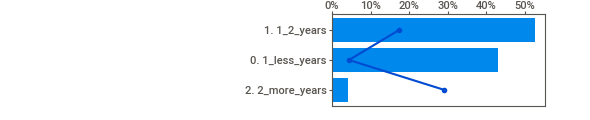
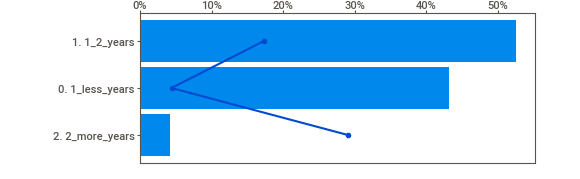
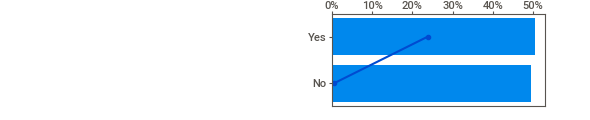
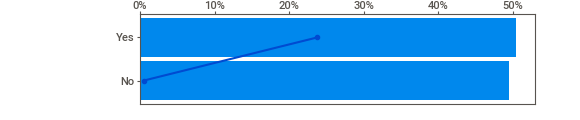
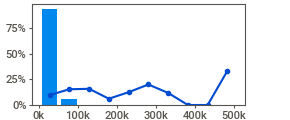
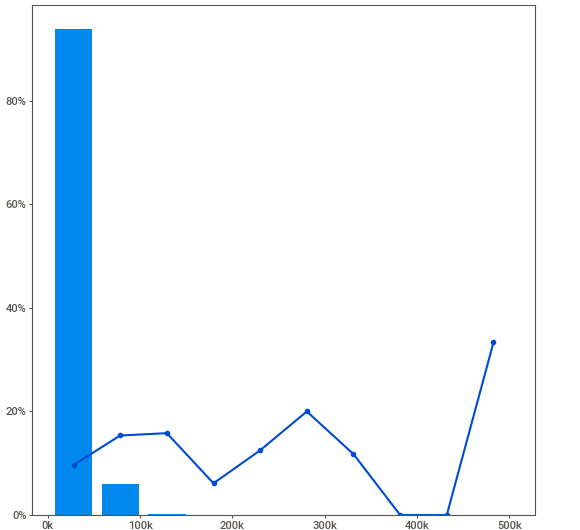
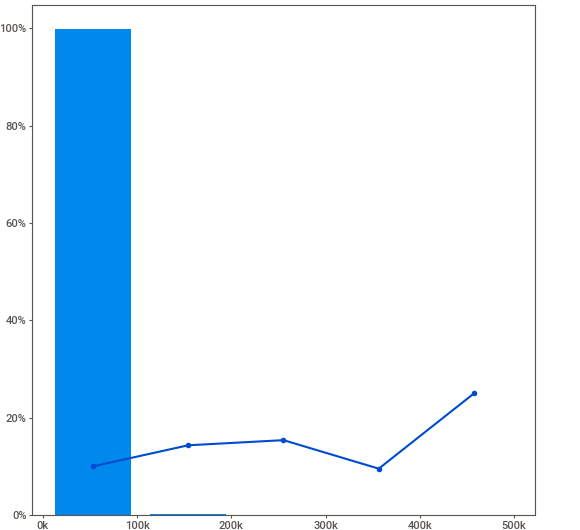
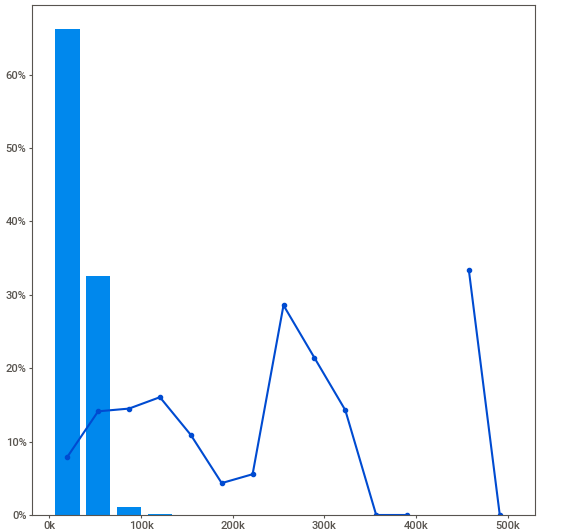
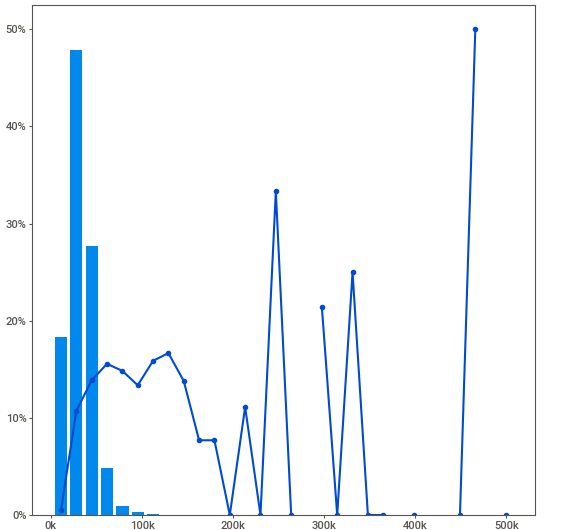
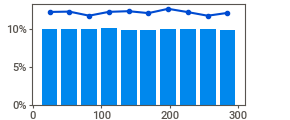
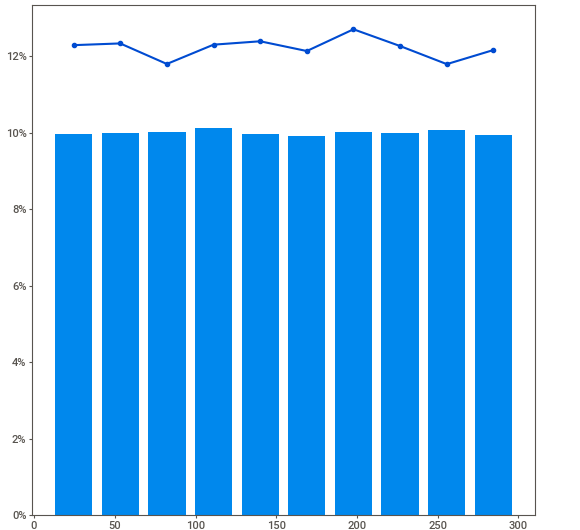
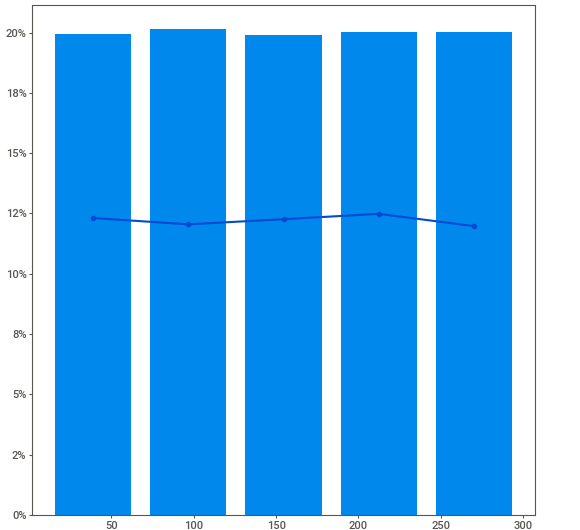
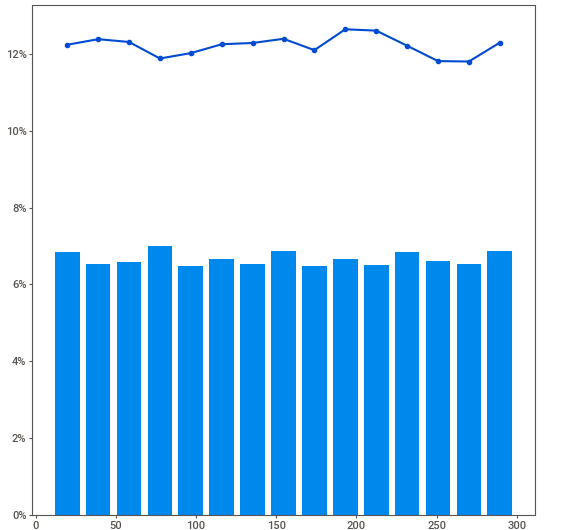
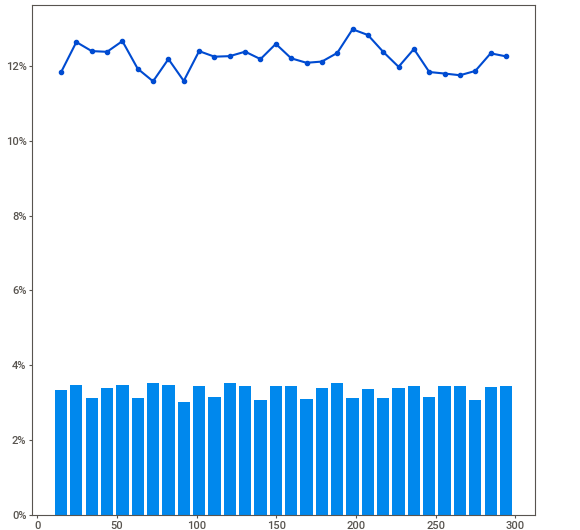
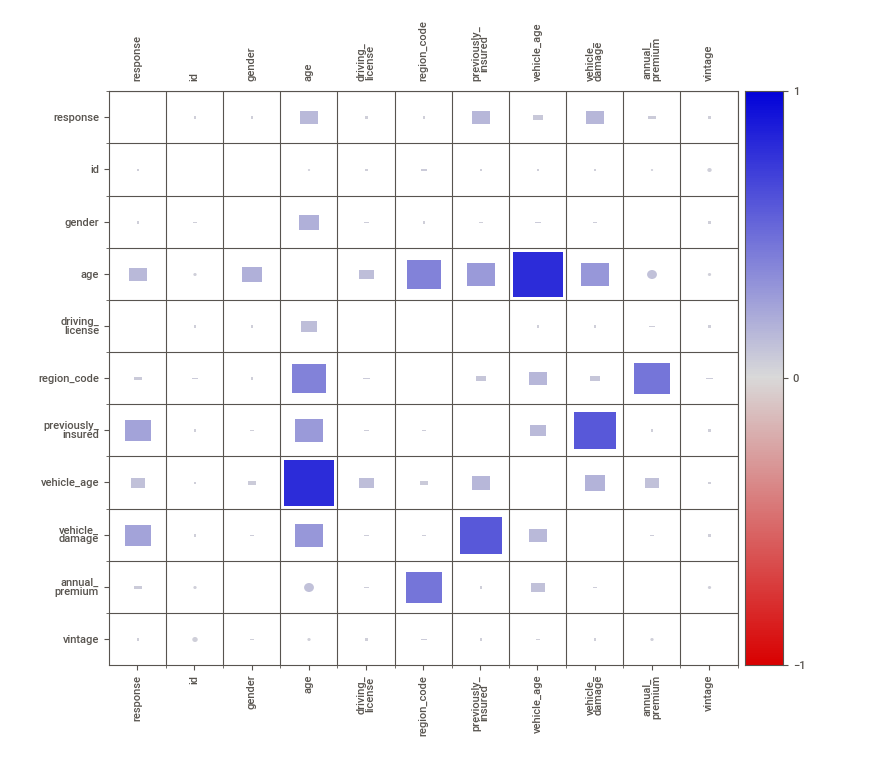
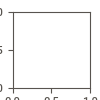

In [22]:
my_report = sv.analyze(df2,target_feat='response')
my_report.show_html("descritive analysis.html")
my_report.show_notebook()

In [23]:
df4.select_dtypes(include='object').columns

Index(['gender', 'region_code', 'vehicle_age', 'vehicle_damage',
       'policy_sales_channel'],
      dtype='object')

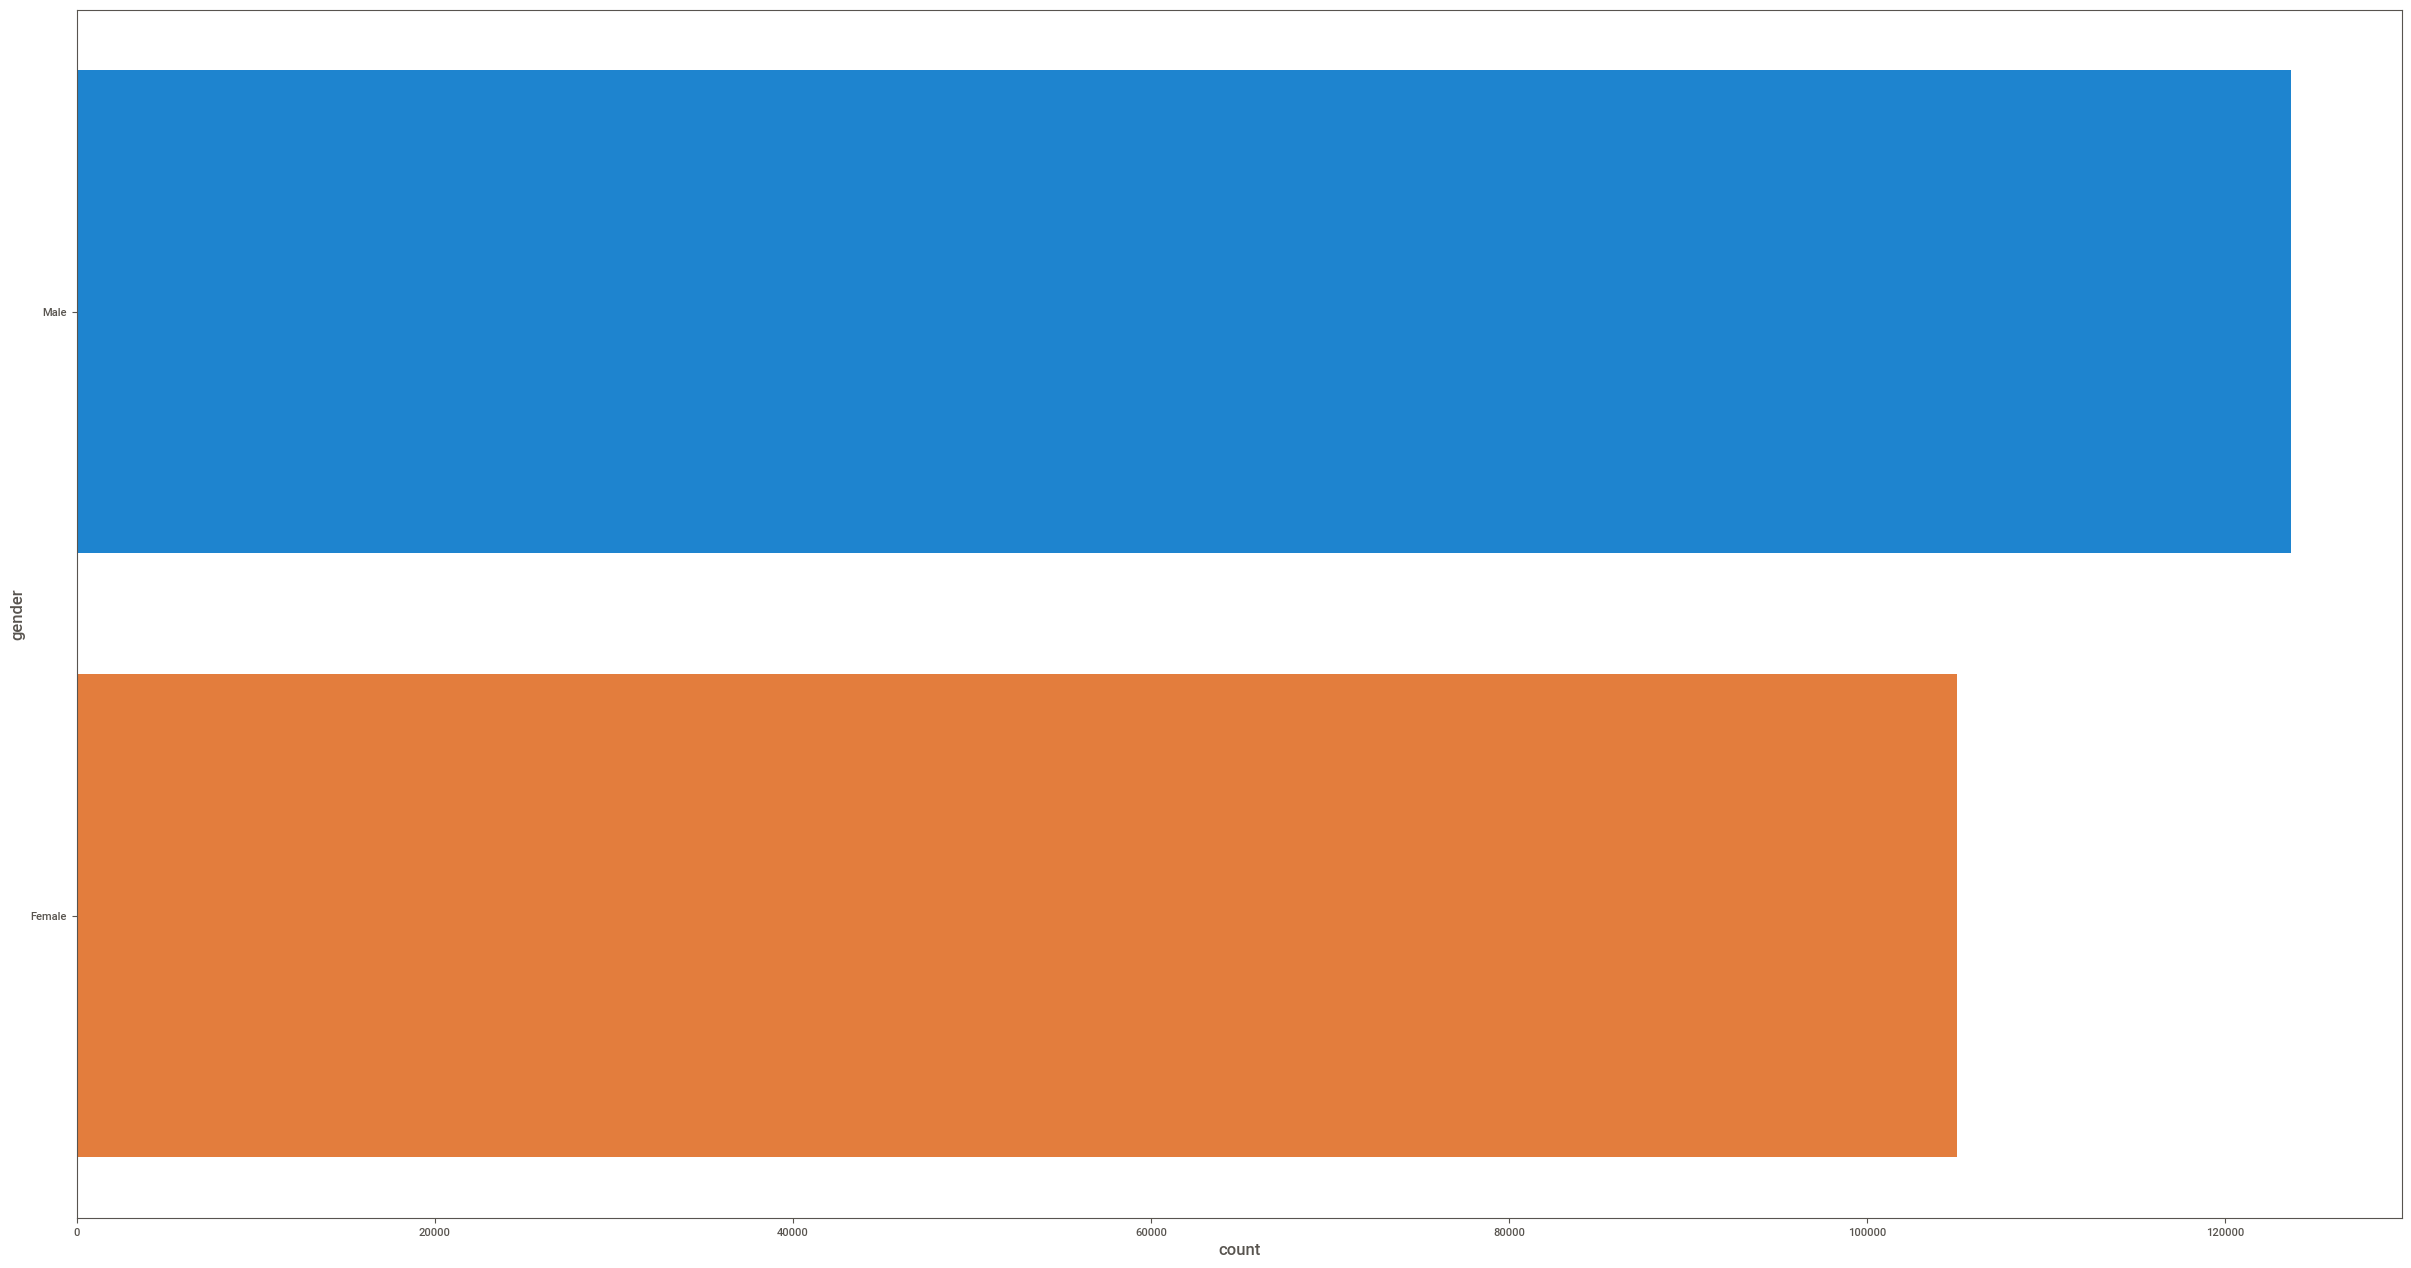

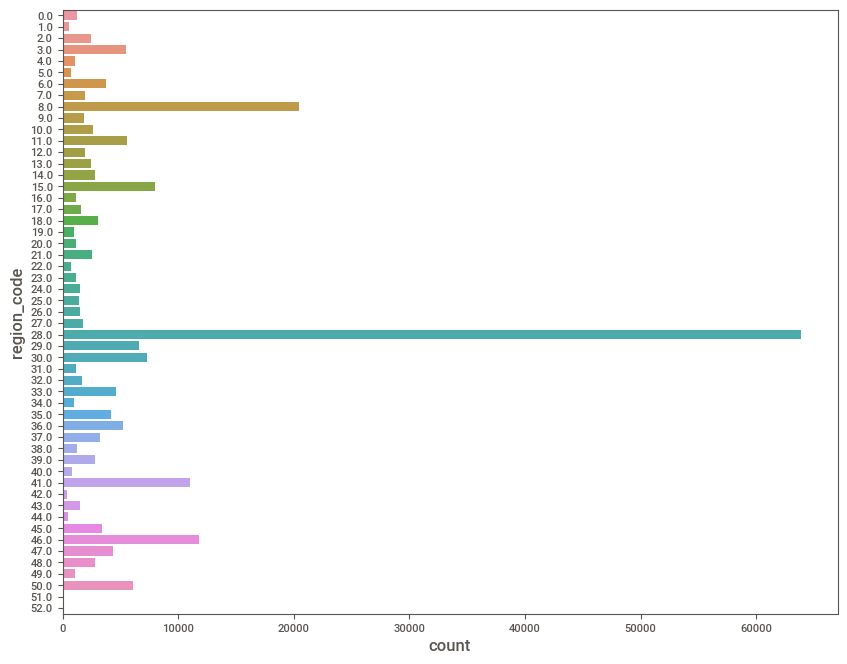

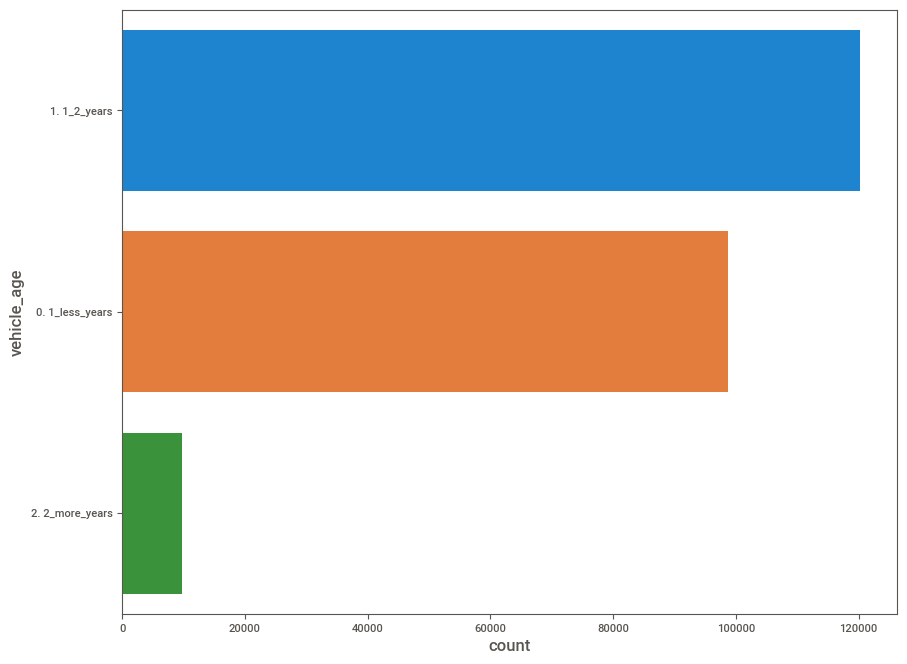

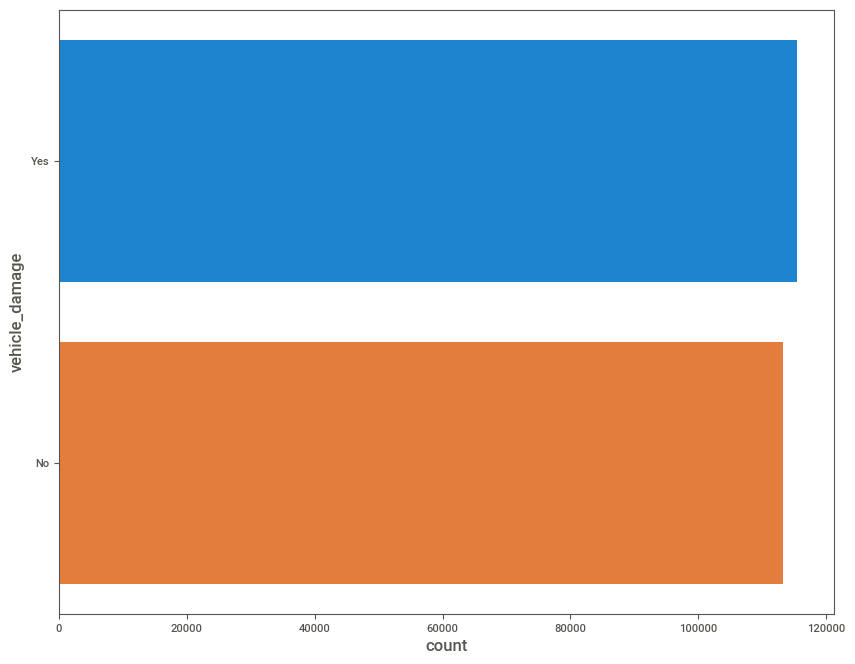

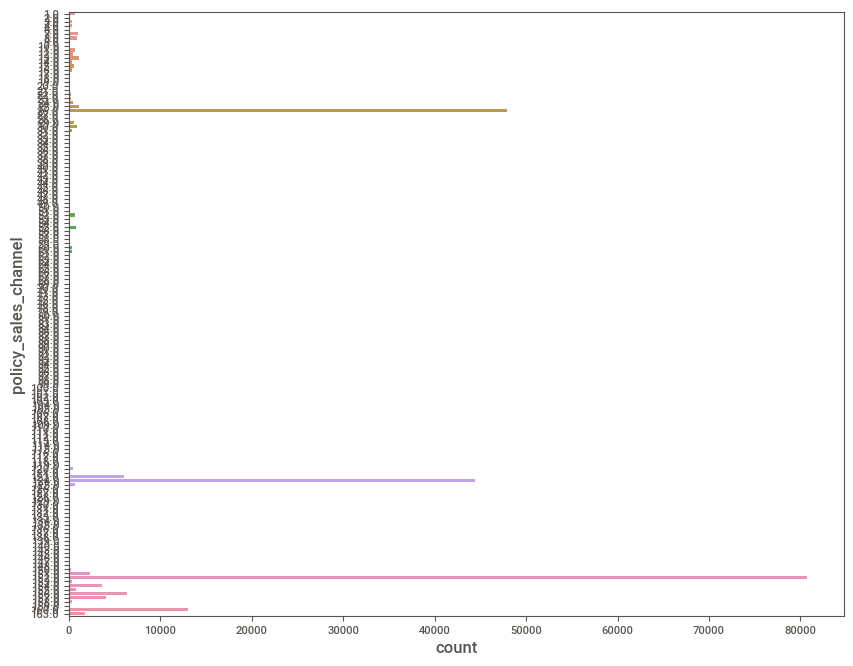

<Figure size 1000x800 with 0 Axes>

In [24]:
for i in df4.select_dtypes(include='object').columns:
    sns.countplot(y=df4[i])
    plt.show()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)

## 4.2 bivariate analysis and hypoteses testing

### H1. Customers with HIGH ASSOCIATE TIME with the company buys MORE vehicle insurance.
### **FALSE** There's no relationship between Associate Time and propensity buting vehicle insurance.

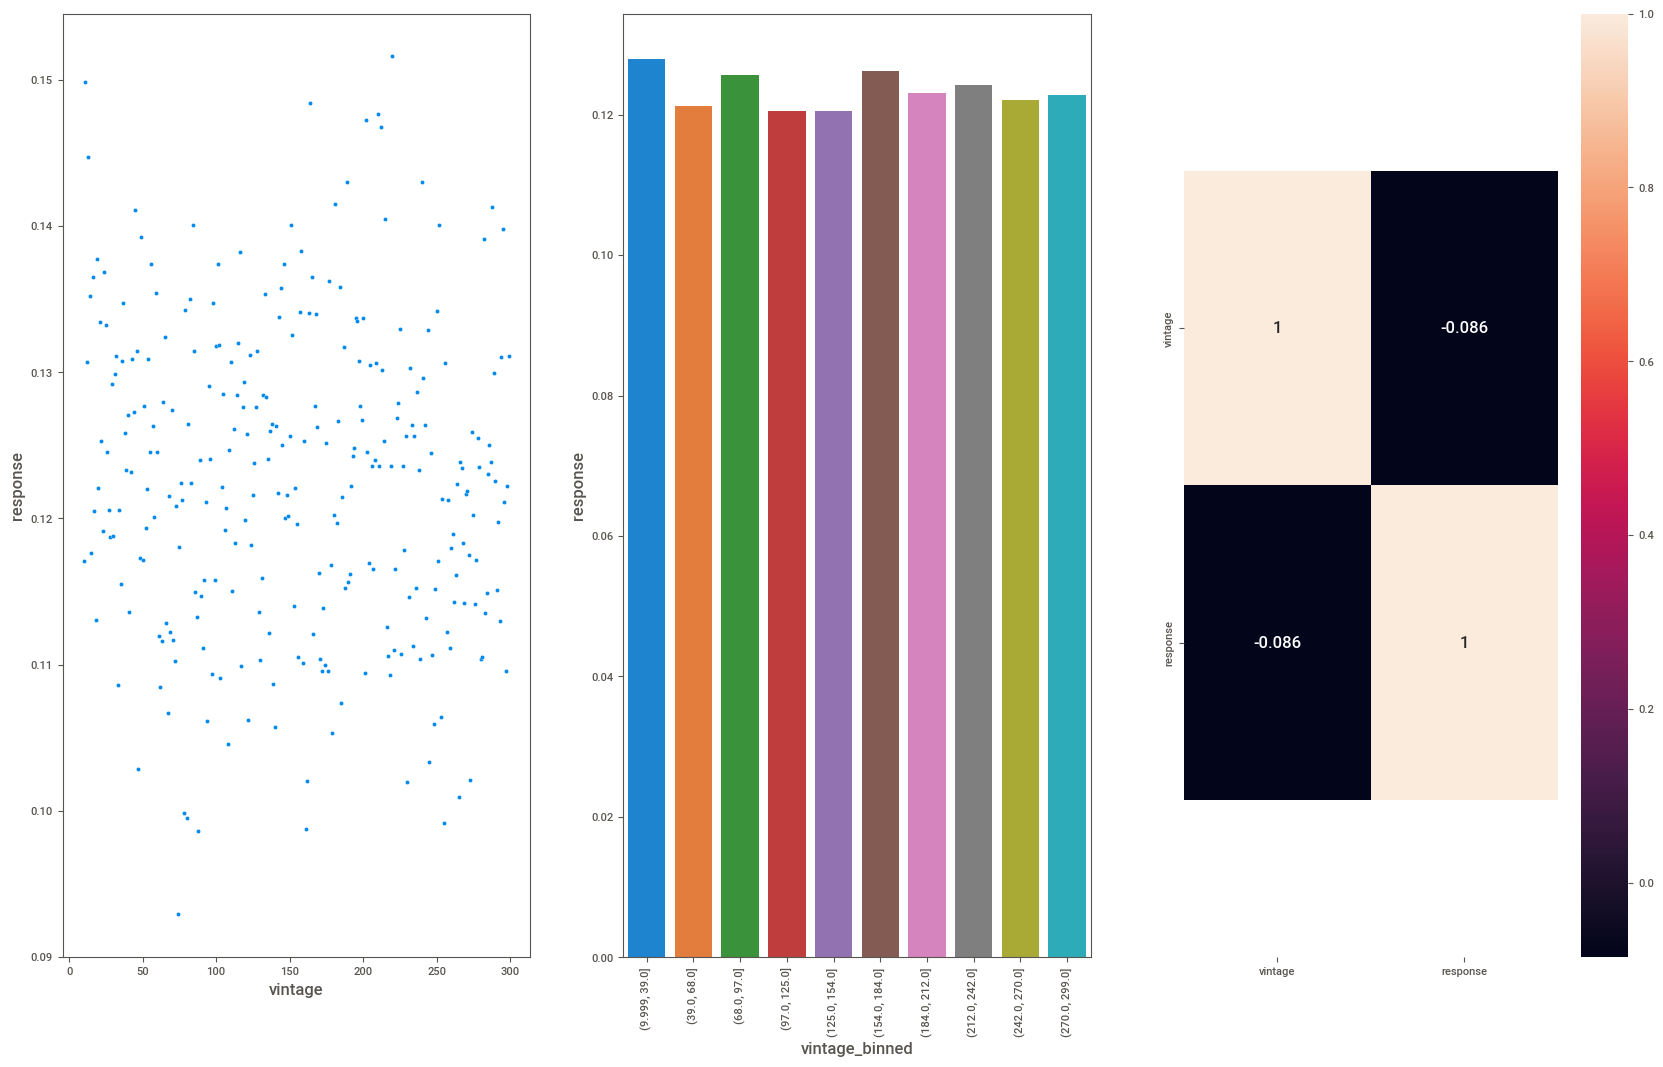

In [25]:
aux1 = df4[['vintage', 'response']].groupby( 'vintage' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='vintage', y='response', data=aux1 );

plt.subplot( 1, 3, 2 )
aux1['vintage_binned']=pd.qcut(df4['vintage'],10)
aux2 = aux1[['vintage_binned', 'response']].groupby( 'vintage_binned' ).mean().reset_index()
sns.barplot( x='vintage_binned', y='response', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### H2. Previously insured customers buys MORE vehicle insurance.
### **FALSE** Previously insured customers buys LESS vehicle insurance.

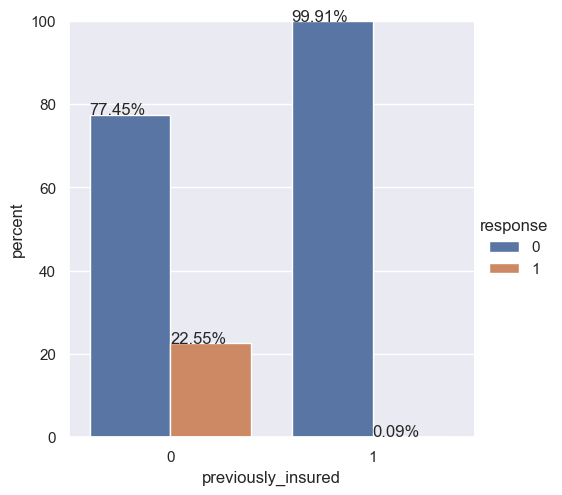

In [26]:
sns.set(rc={'figure.figsize':(10,8)})


aux = df4.groupby('previously_insured')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='previously_insured',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)


### H3. Customers with driver licence buys MORE vehicle insurance.
### **TRUE** Customers with driver licence buys MORE vehicle insurance.

In [27]:
aux.columns

Index(['previously_insured', 'response', 'percent'], dtype='object')

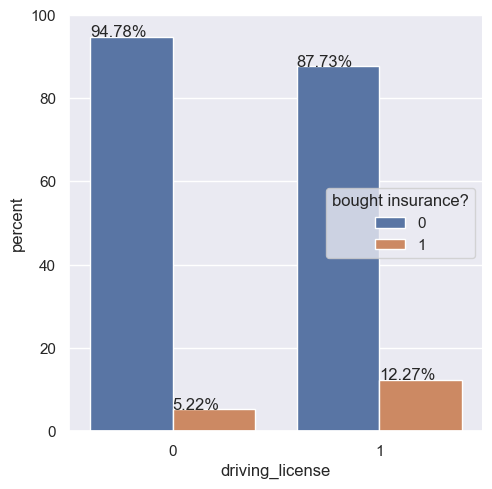

In [28]:
sns.set(rc={'figure.figsize':(10,8)})


aux = df4.groupby('driving_license')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='driving_license',y='percent',hue='response',kind='bar',data=aux,legend=False)
g.ax.set_ylim(0,100)
plt.gca().legend(title='bought insurance?', loc='center right')

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### **H4.** OLDERS customers buys MORE vehicle insurance.
### **FALSE** OLDERS customers buys LESS vehicle insurance, but the youngest customers either.

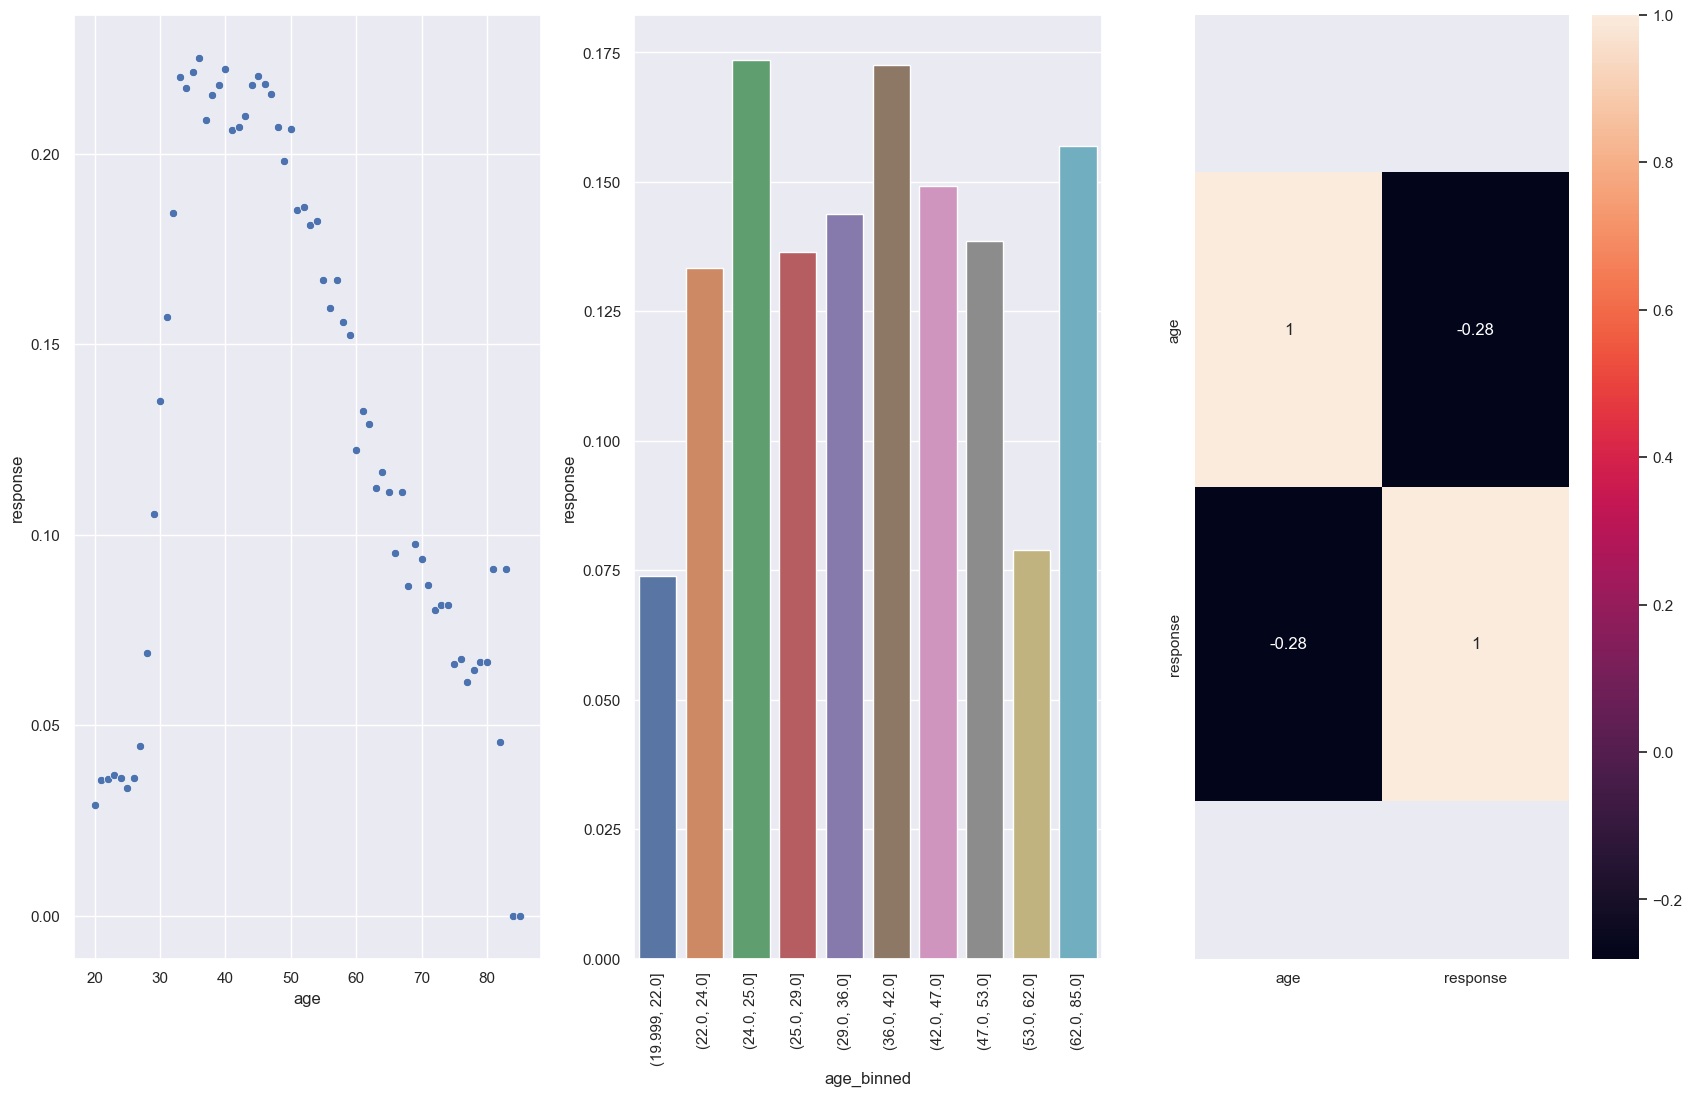

In [29]:
aux1 = df4[['age', 'response']].groupby( 'age' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='age', y='response', data=aux1 );

plt.subplot( 1, 3, 2 )
aux1['age_binned']=pd.qcut(df4['age'],10)
aux2 = aux1[['age_binned', 'response']].groupby( 'age_binned' ).mean().reset_index()
sns.barplot( x='age_binned', y='response', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### **H5.** There's a difference in propensity to purchase between customers GENDERS.
### **True** MALE customers are slighly more likely to buy vehicle insurance.

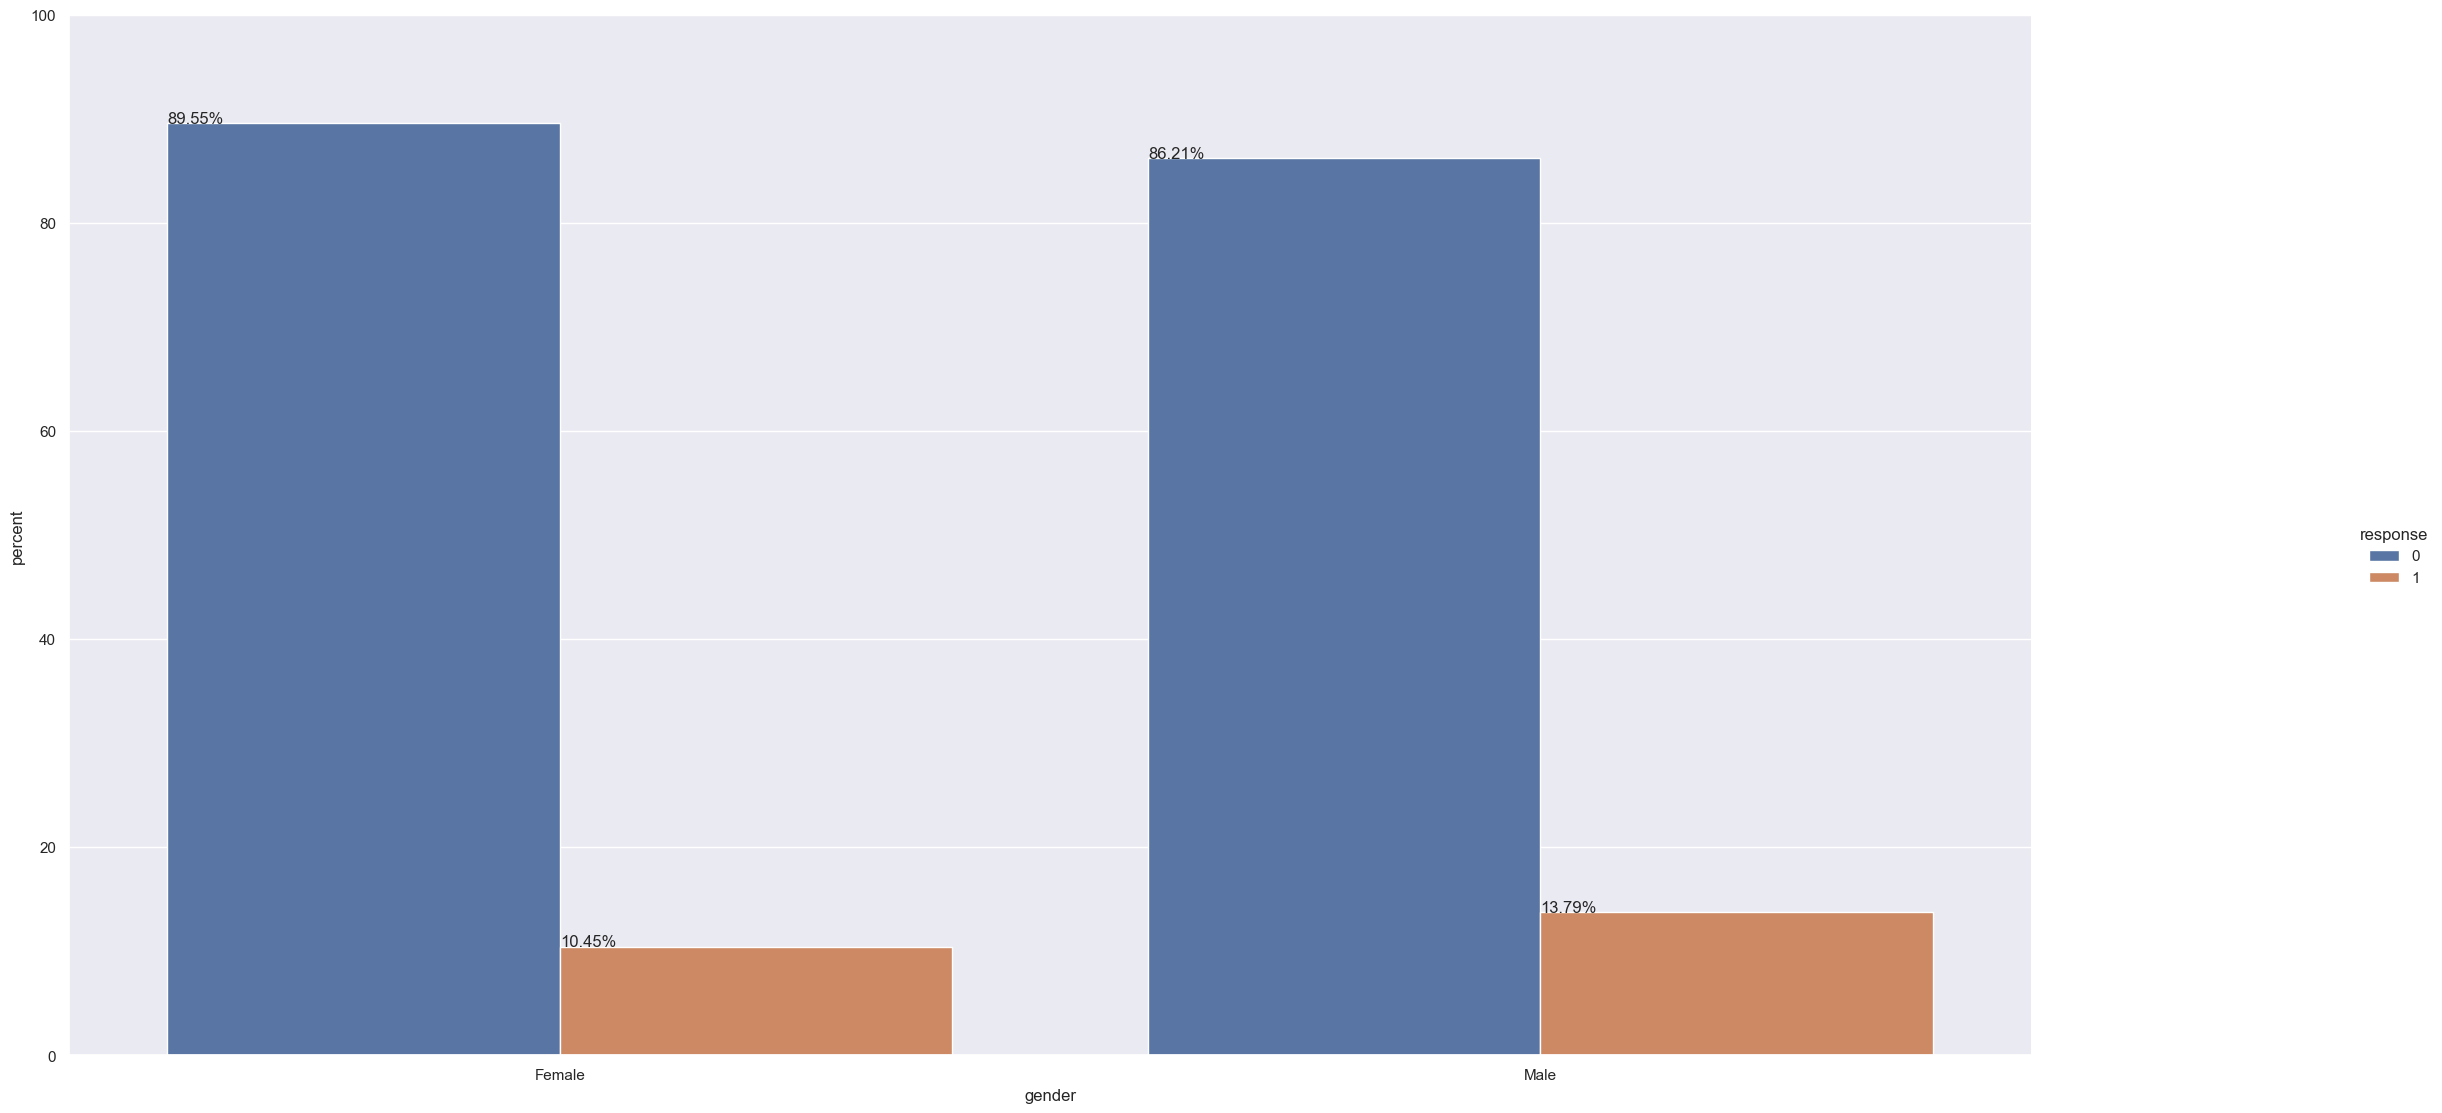

In [30]:
aux = df4.groupby('gender')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='gender',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H6. There's a DIFFERENCE in propensity to purchase between REGION CODE
### True. There's regions with more propense purchase customers.

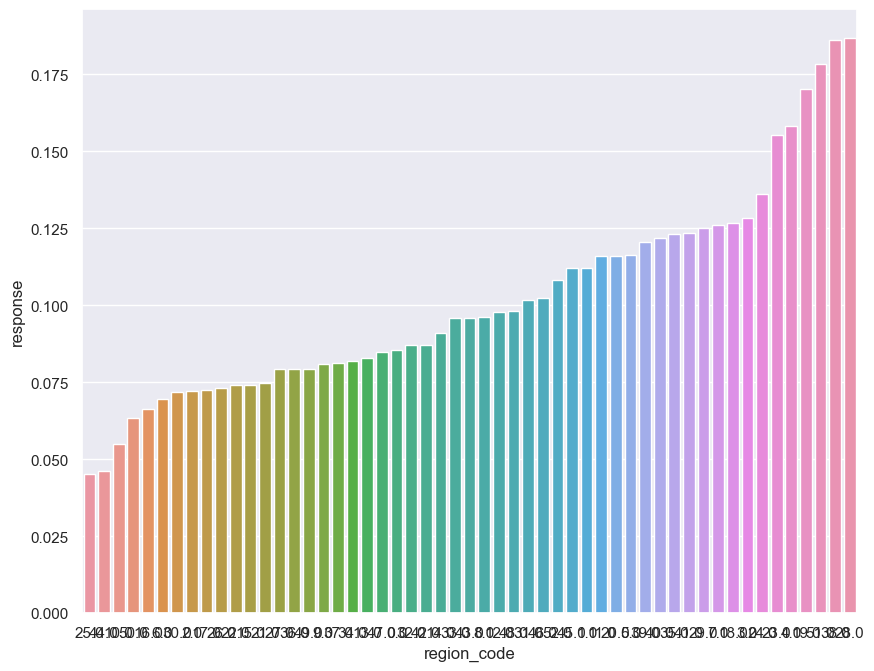

In [31]:
aux1 = df4[['region_code', 'response']].groupby( 'region_code' ).mean().reset_index().sort_values('response')
aux1['region_code']=aux1['region_code'].astype(str)

sns.barplot( x='region_code', y='response' ,data=aux1);

### H7. Customers with HIGH vehicle insurance price should buys LESS vehicle insurance.
### FALSE the HIGHEST insurance prices is MORE BOUGHT by customers.

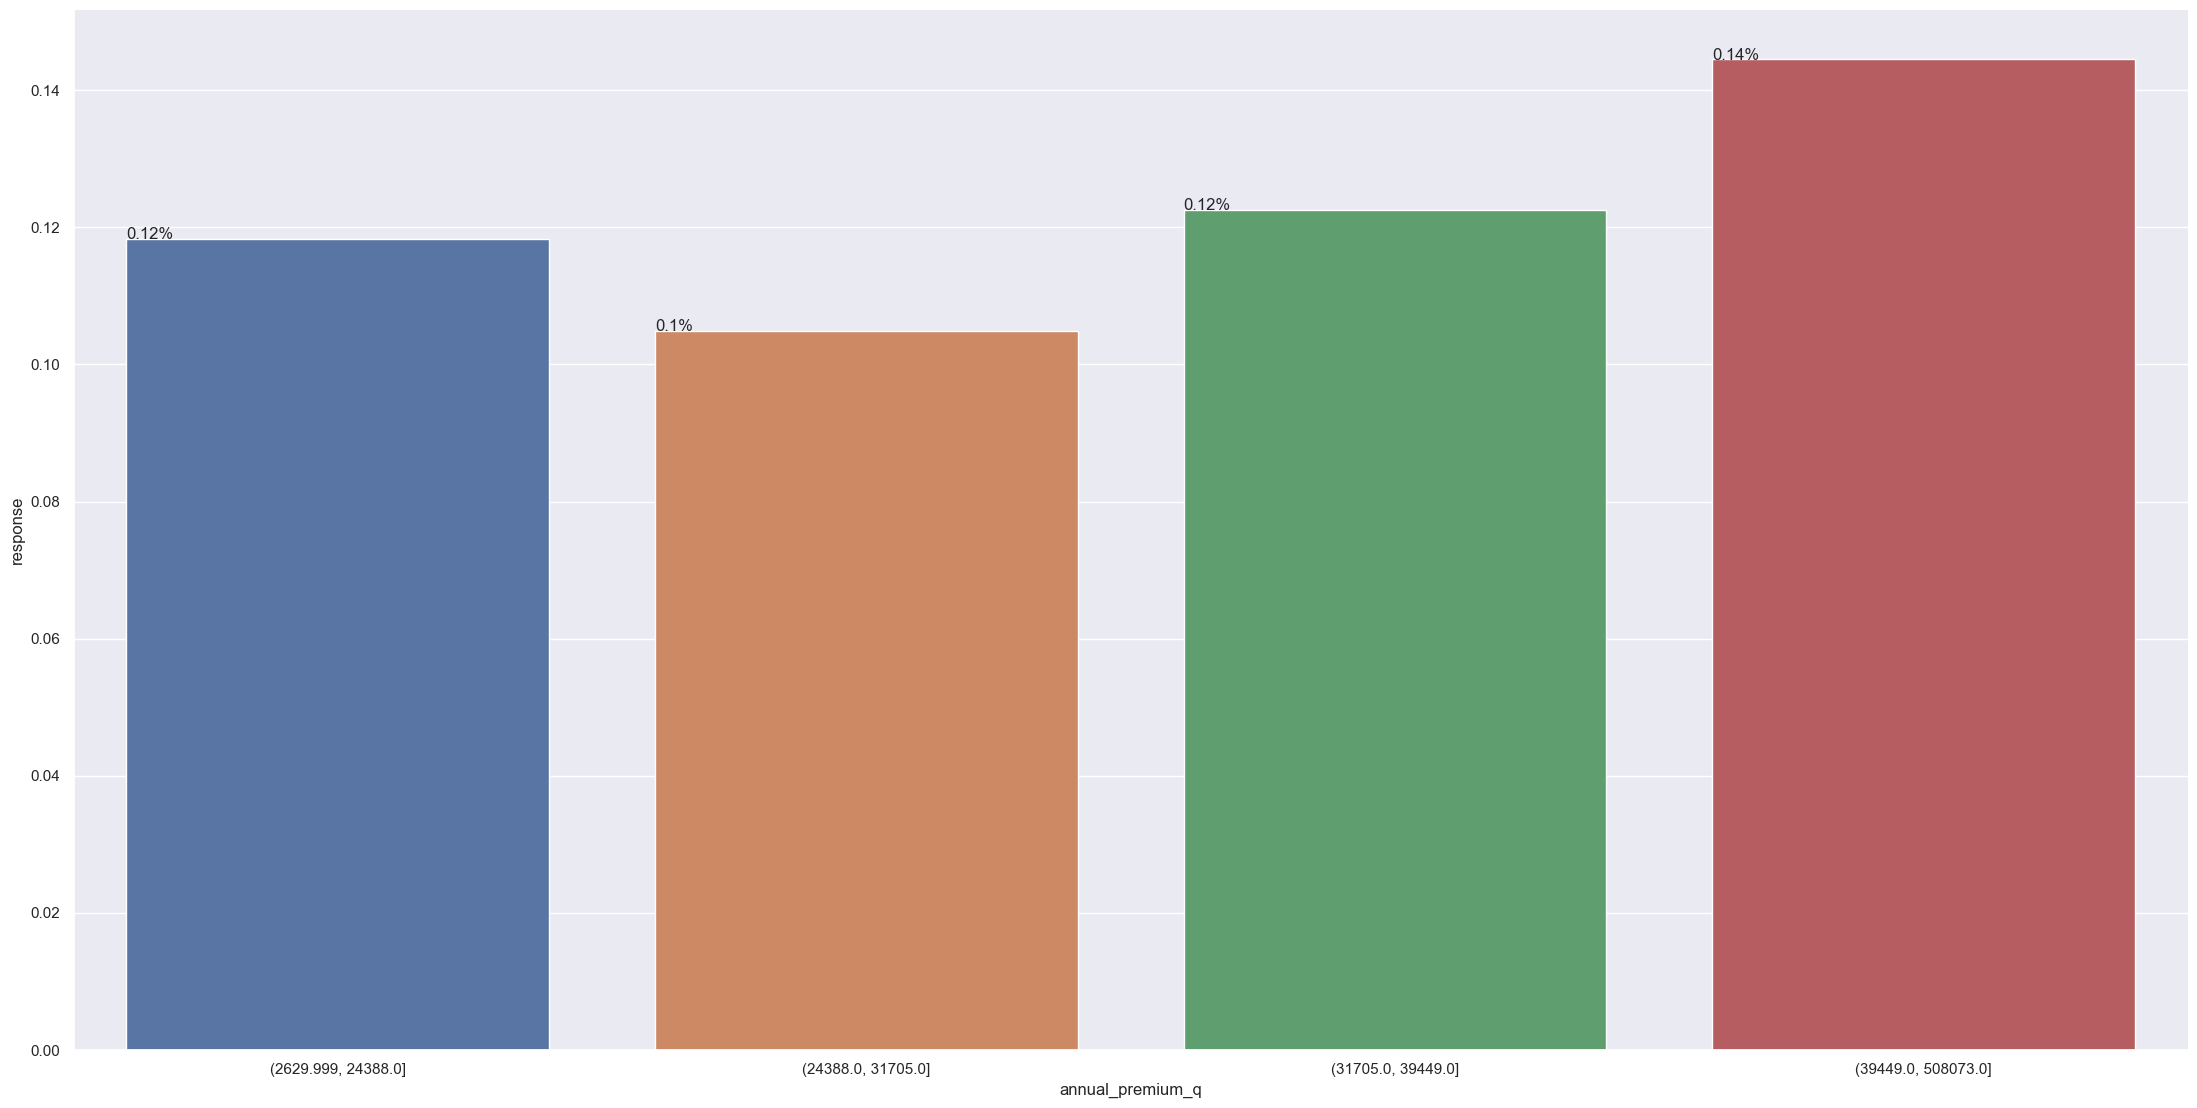

In [32]:
aux1=df4.copy()
aux1['annual_premium_q']=pd.qcut(aux1['annual_premium'],4)
aux1=aux1.groupby(['annual_premium_q']).agg({'response':'mean'}).reset_index()
g=sns.catplot(x='annual_premium_q',y='response',data=aux1,kind='bar')
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H8. UNDERAGED vehicles are MORE likely to be insured by customers.
###  **TRUE** UNDERAGED vehicles are MORE likely to be insured by customers.

1. 1_2_years       120283
0. 1_less_years     98690
2. 2_more_years      9692
Name: vehicle_age, dtype: int64


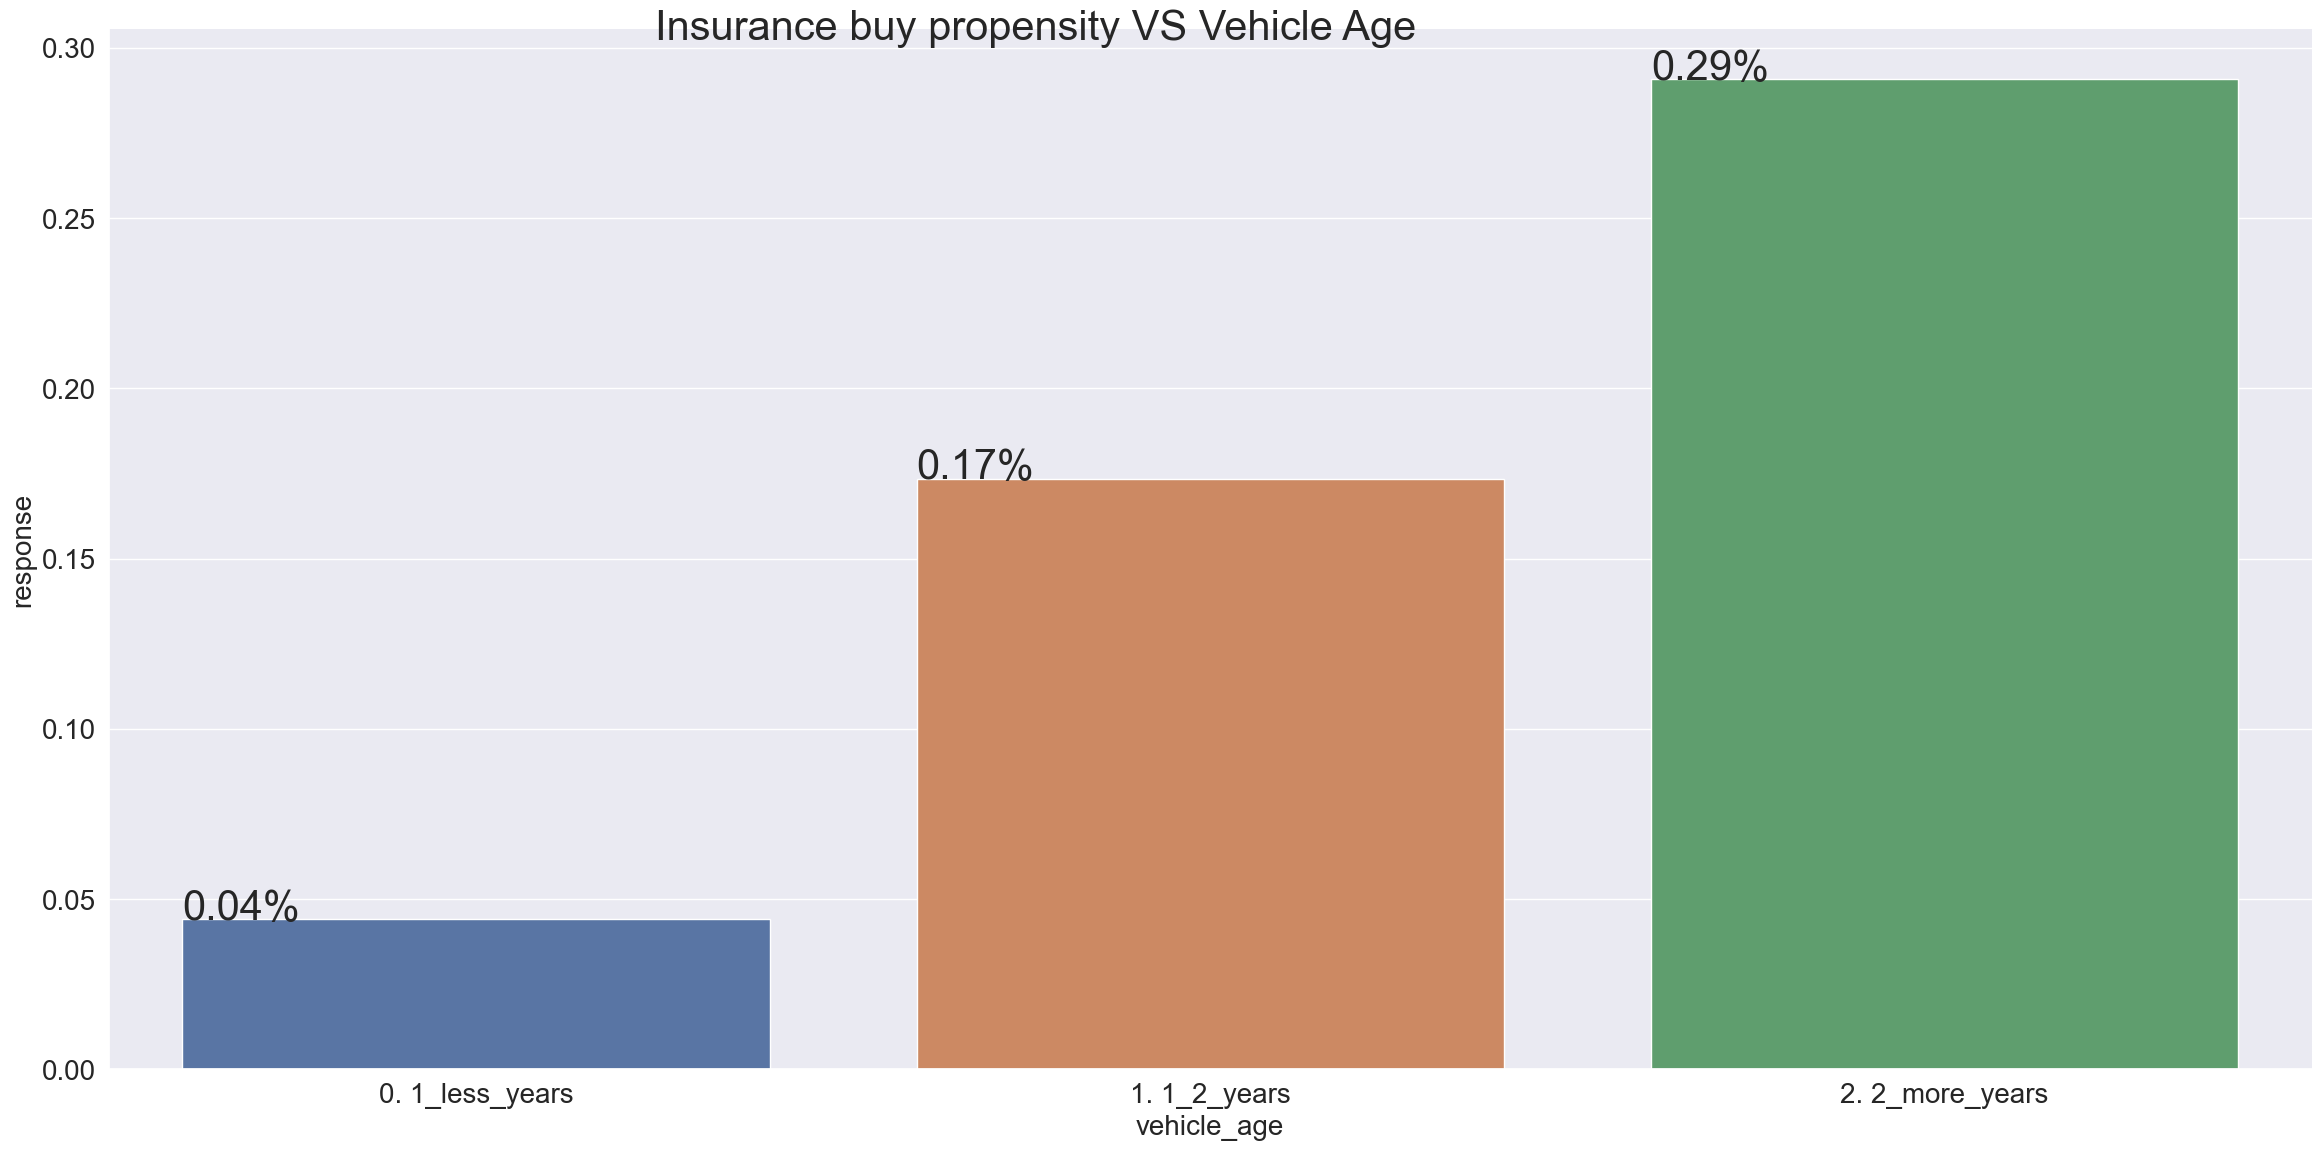

In [33]:
aux1 = df4[['vehicle_age', 'response']].groupby( 'vehicle_age' ).mean().reset_index().sort_values('response')
aux1['vehicle_age']=aux1['vehicle_age'].astype(str)
print(df4['vehicle_age'].value_counts())
g=sns.catplot(x='vehicle_age',y='response',data=aux1,kind='bar')
g.ax.tick_params(axis='both', labelsize=20)
g.ax.xaxis.label.set_size(20)
g.ax.yaxis.label.set_size(20)
plt.suptitle("Insurance buy propensity VS Vehicle Age",fontsize=30)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt,fontsize=30)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H9. DAMAGED vehicles are MORE likely to be insured by customers.

###  **True** DAMAGED vehicles are MUCH MORE LIKELY to be insured by customers.

<AxesSubplot:xlabel='vehicle_damage', ylabel='response_count'>

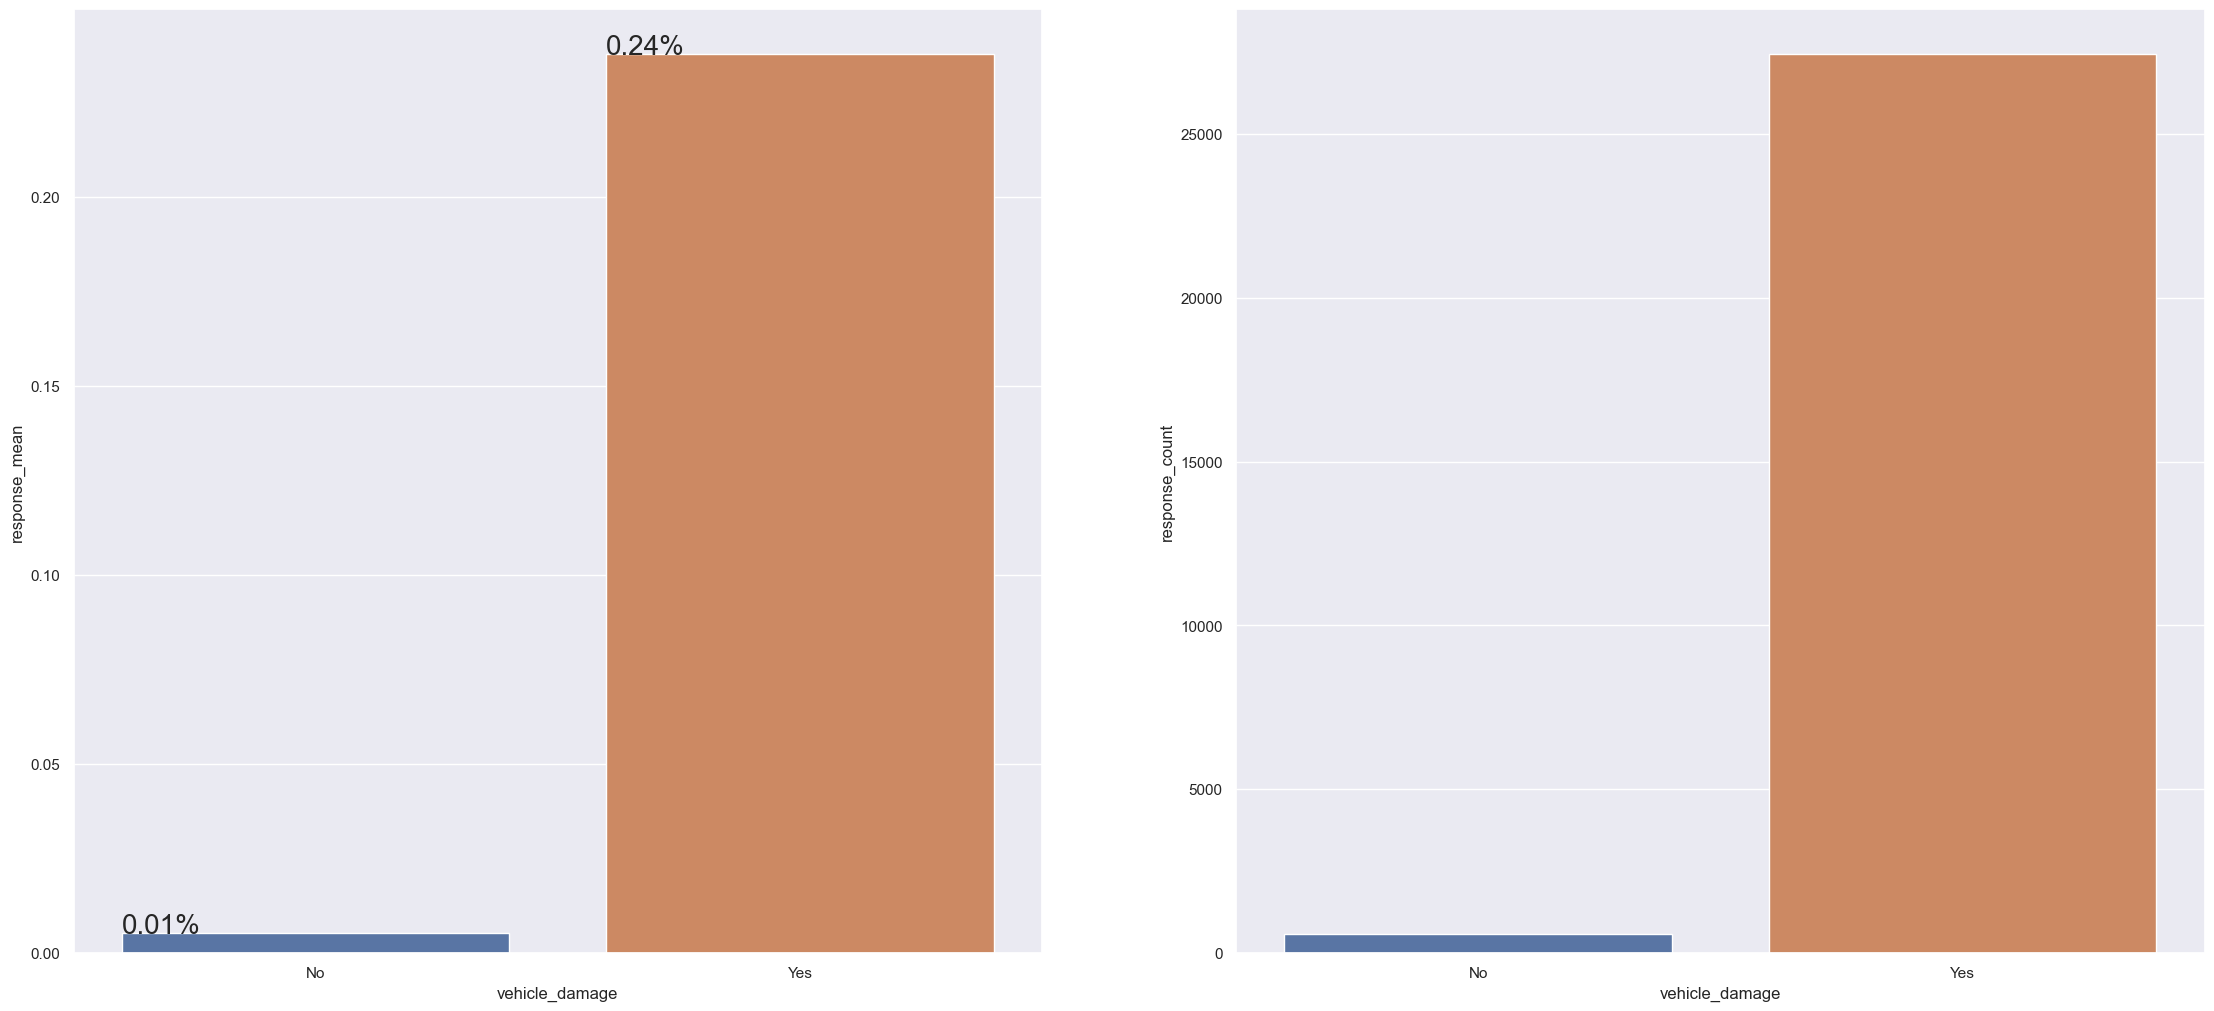

In [34]:
aux1 = df4.groupby( 'vehicle_damage').agg(response_count=('response','sum'),
                                                response_mean=('response','mean')).reset_index().sort_values('vehicle_damage')

fig = plt.figure(figsize=(20,10))
specs=gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1= fig.add_subplot(specs[0,0])
ax2= fig.add_subplot(specs[0,1])

g=sns.barplot(x='vehicle_damage',y='response_mean',data=aux1,ax=ax1)
for p in g.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt,fontsize=20)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)
sns.barplot(x='vehicle_damage',y='response_count',data=aux1,ax=ax2)


### H9. There is different insurance buy propensity according to policy sales channel. 

###  **True** there is a considerable difference in buy propensity depending to policy sales channel, however there is a big imbalance between the channels.

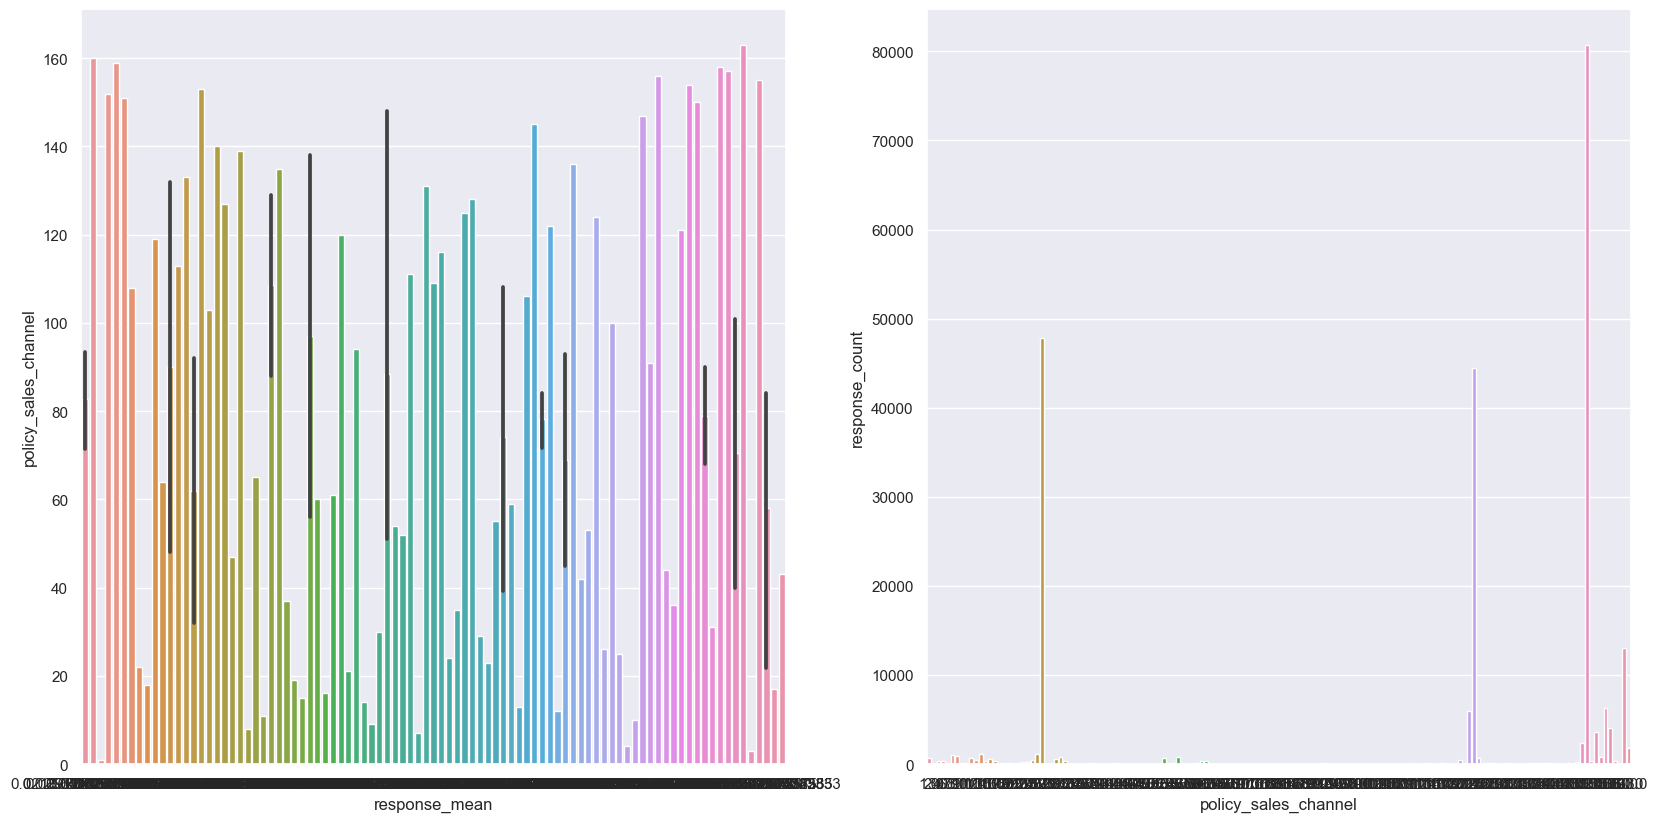

In [35]:
aux1 = df4.groupby( 'policy_sales_channel' ).agg(response_count=('response','count'),
                                                response_mean=('response','mean')).reset_index().sort_values('policy_sales_channel')

fig = plt.figure(figsize=(20,10))
specs=gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1= fig.add_subplot(specs[0,0])
ax2= fig.add_subplot(specs[0,1])

g=sns.barplot(y='policy_sales_channel',x='response_mean',data=aux1,ax=ax1)
g=sns.barplot(x='policy_sales_channel',y='response_count',data=aux1,ax=ax2)


## hypoteses summary

In [36]:
hyp={
"Customers with HIGH ASSOCIATE TIME with the company buys MORE vehicle insurance.":False,
"Customers previously insured buys MORE vehicle insurance.":False,
"Customers with driver licence buys MORE vehicle insurance.":True,
"OLDERS customers buys MORE vehicle insurance.":False,
"There's a difference in propensity to purchase between customers GENDERS.":True,
"There's a difference in propensity to purchase between region CODE":True,
"Customers with HIGH vehicle insurance price should buys LESS vehicle insurance.":False,
"UNDERAGED vehicles are MORE likely to be insured by customers.":True,
"There is different insurance buy propensity according to Policy Sales Channel.":True,
}
summary=pd.DataFrame.from_dict(hyp,orient='index').reset_index().rename(columns={'index':'hypotesis',0:'Conclusion'})
summary

,hypotesis,Conclusion
0,Customers with HIGH ASSOCIATE TIME with the co...,False
1,Customers previously insured buys MORE vehicle...,False
2,Customers with driver licence buys MORE vehicl...,True
3,OLDERS customers buys MORE vehicle insurance.,False
4,There's a difference in propensity to purchase...,True
5,There's a difference in propensity to purchase...,True
6,Customers with HIGH vehicle insurance price sh...,False
7,UNDERAGED vehicles are MORE likely to be insur...,True
8,There is different insurance buy propensity ac...,True


## 4.3 multivariate analysis

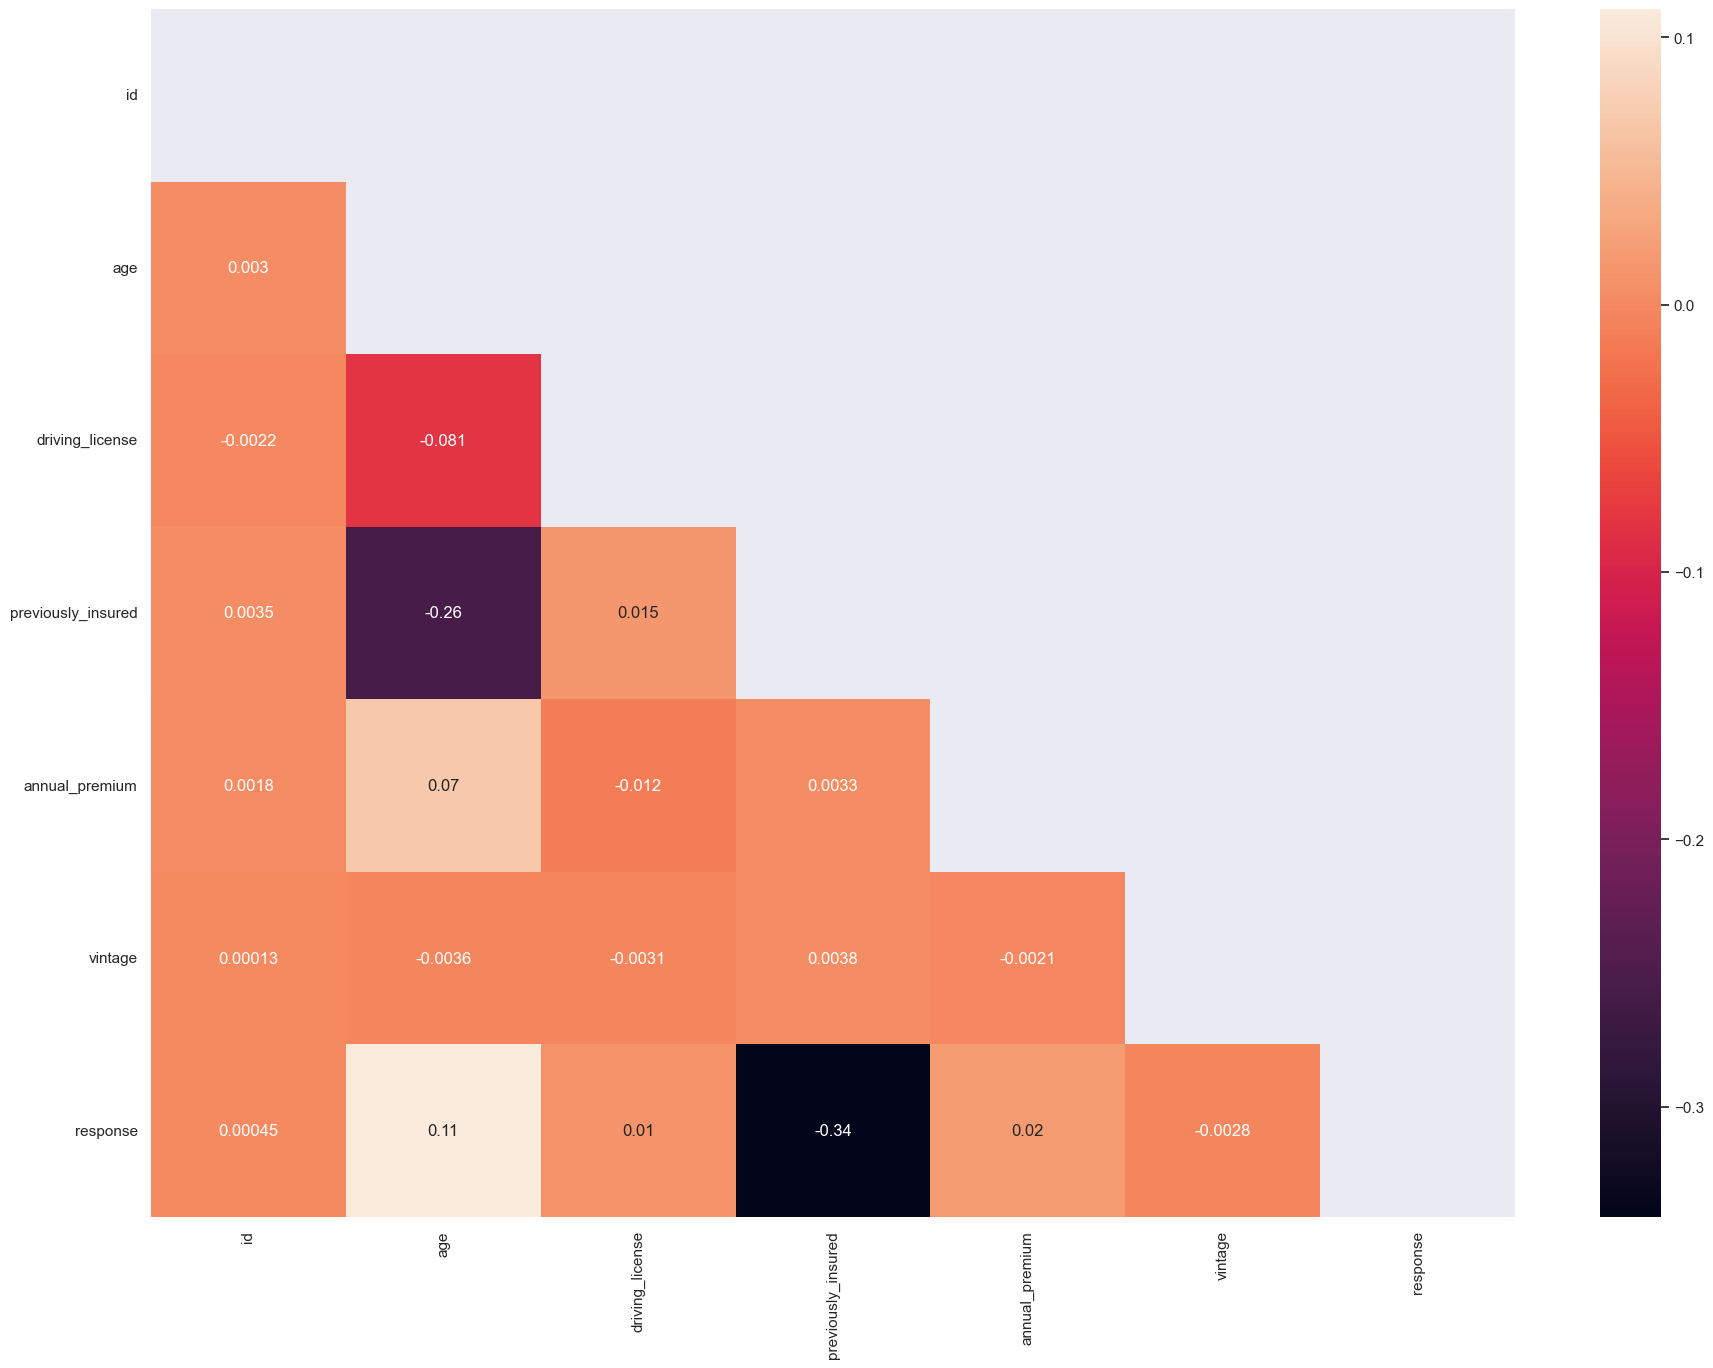

In [37]:
corrs= df2.select_dtypes(include=['float64','int64']).corr(method='pearson')
matrix = np.triu(corrs)
sns.heatmap(corrs,annot=True,mask=matrix)
plt.gcf().set_size_inches(22,16)

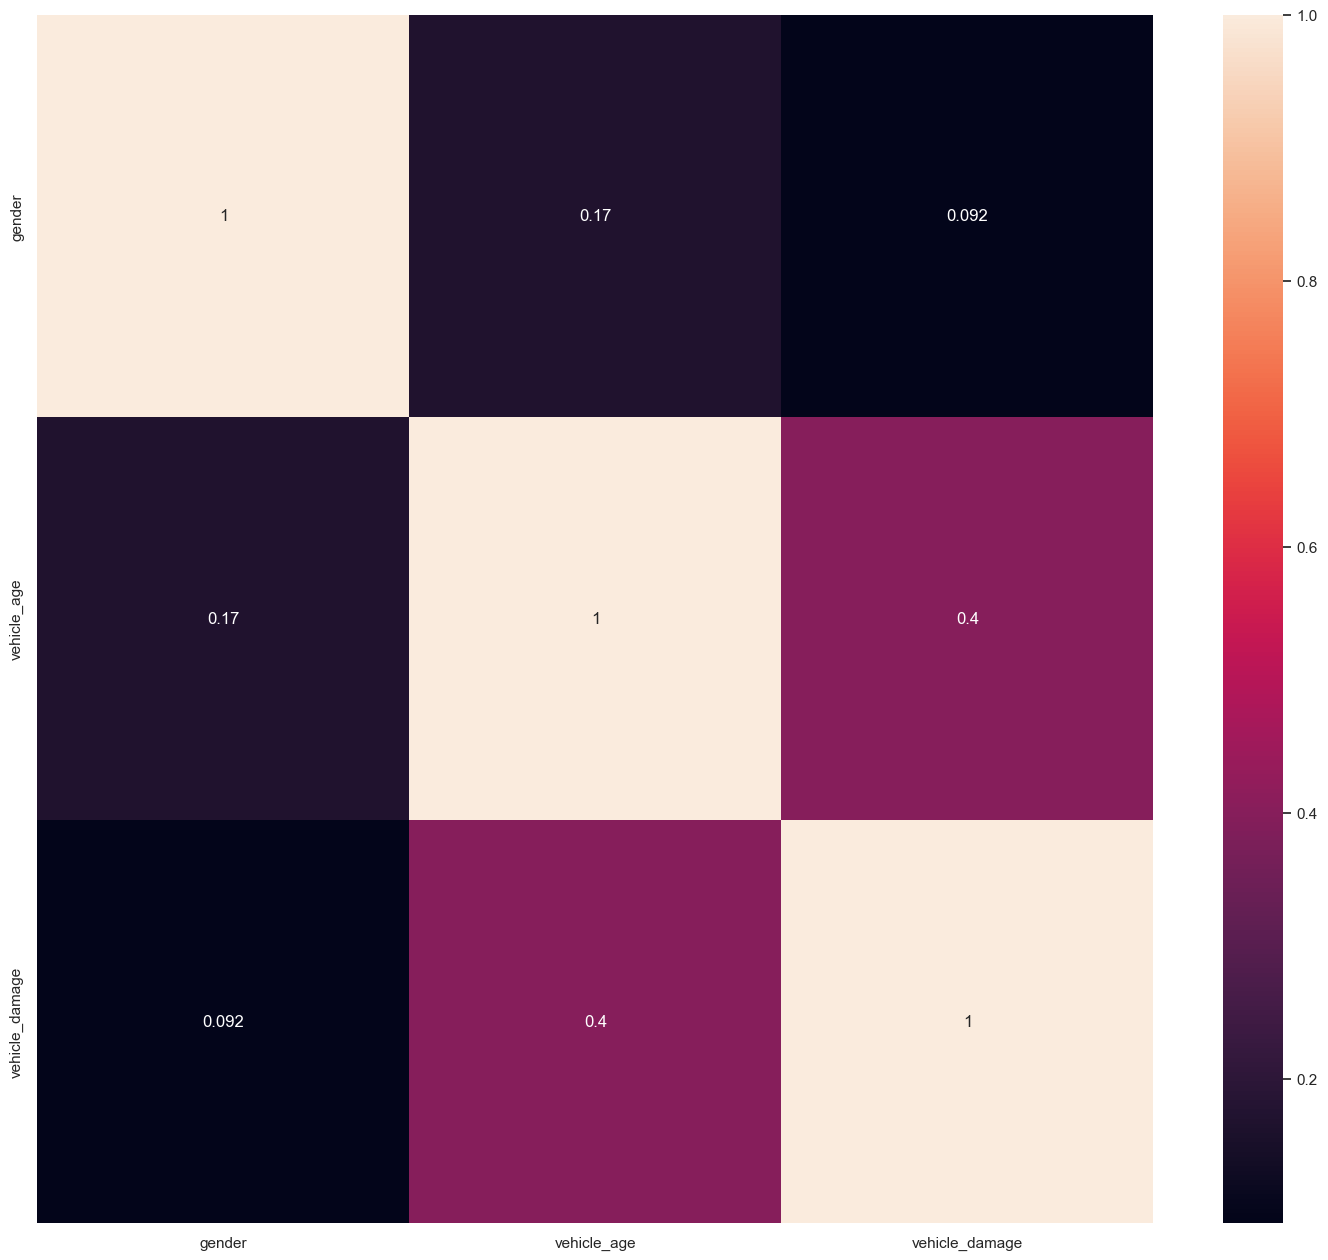

In [38]:
# Calculate cramer V
a1 = cramer_v( df2['gender'], df2['gender'] )
a2 = cramer_v( df2['gender'], df2['vehicle_age'] )
a3 = cramer_v( df2['gender'], df2['vehicle_damage'] )

a4 = cramer_v( df2['vehicle_age'], df2['gender'] )
a5 = cramer_v( df2['vehicle_age'], df2['vehicle_age'] )
a6 = cramer_v( df2['vehicle_age'], df2['vehicle_damage'] )

a7 = cramer_v( df2['vehicle_damage'], df2['gender'] )
a8 = cramer_v( df2['vehicle_damage'], df2['vehicle_age'] )
a9 = cramer_v( df2['vehicle_damage'], df2['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
               'vehicle_age': [a4, a5, a6],
               'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )



sns.heatmap( d, annot=True)
plt.gcf().set_size_inches(18,16)

# 5.0 DATA PREPARATION

In [39]:
df5=df4.copy()

#make directory to save the serialized transformers
os.makedirs("parameters",exist_ok=True)

In [40]:
df5=pickle.load(open("df5.pkl",'rb'))
df5.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,Male,49,1,41.00000,0,1. 1_2_years,Yes,30123.00000,124.00000,109,0
244933,244934,Female,64,1,8.00000,0,1. 1_2_years,Yes,40700.00000,124.00000,241,0


## 5.1 Encoding

In [41]:
obj=df5.select_dtypes(include='object').columns
df5[obj].nunique()

gender                    2
region_code              53
vehicle_age               3
vehicle_damage            2
policy_sales_channel    150
dtype: int64

In [42]:
#Ordinal Encoding
oe=OrdinalEncoder()
df5[['vehicle_age','gender','vehicle_damage']]=oe.fit_transform(df5[['vehicle_age','gender','vehicle_damage']])
pickle.dump(oe,open("parameters/oe_vehicle_age_gender_vehicle_damage.pkl","wb"))
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,1.00000,49,1,41.00000,0,1.00000,1.00000,30123.00000,124.00000,109,0
244933,244934,0.00000,64,1,8.00000,0,1.00000,1.00000,40700.00000,124.00000,241,0
189344,189345,0.00000,24,1,11.00000,1,0.00000,0.00000,2630.00000,152.00000,120,0
232120,232121,0.00000,43,1,17.00000,1,1.00000,0.00000,2630.00000,152.00000,159,0
304224,304225,0.00000,29,1,10.00000,1,0.00000,0.00000,2630.00000,152.00000,117,0


## 5.2 Target encoding with additive smoothing

In [43]:
class BayesianEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        self.dic={}
        X2=pd.concat([X,y],axis=1)
        for i in X.columns:
            self.dic[i]=X2.groupby(i)['response'].mean()/X2['response'].mean()
        return self
    def transform(self, X, y=None):
        X2=X.copy()
        for i in self.dic.keys():
            X2[f'{i}']=X2[i].map(self.dic[i])
        return X2

In [44]:
bs=BayesianEncoding()
df5[['policy_sales_channel','region_code']]=bs.fit_transform(df5[['policy_sales_channel','region_code']],y=df5['response'])
pickle.dump( bs, open( f'parameters/bayesian_encoder.pkl', 'wb') )
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,1.00000,49,1,1.00710,0,1.00000,1.00000,30123.00000,1.53489,109,0
244933,244934,0.00000,64,1,0.78537,0,1.00000,1.00000,40700.00000,1.53489,241,0
189344,189345,0.00000,24,1,0.94647,1,0.00000,0.00000,2630.00000,0.23764,120,0
232120,232121,0.00000,43,1,0.59086,1,1.00000,0.00000,2630.00000,0.23764,159,0
304224,304225,0.00000,29,1,0.44775,1,0.00000,0.00000,2630.00000,0.23764,117,0


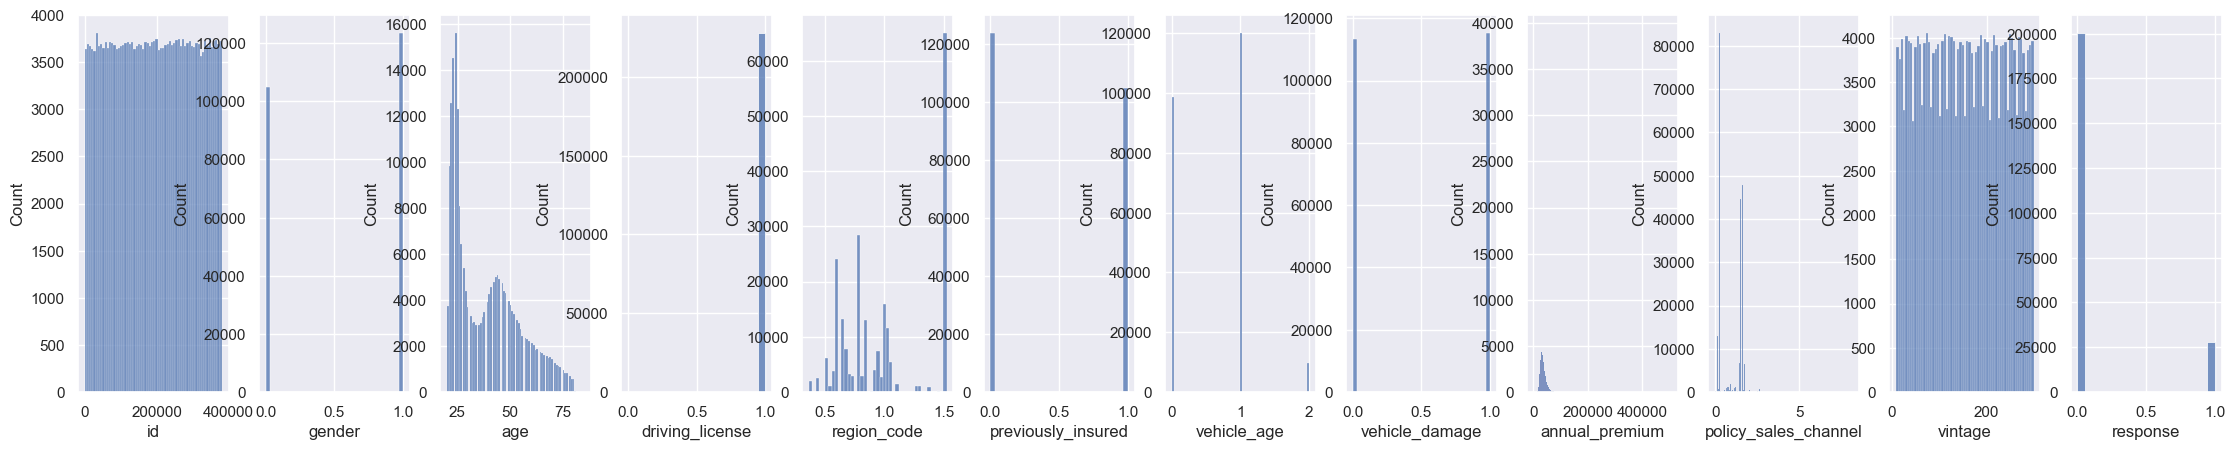

In [45]:
fig = plt.figure(figsize=(30,5))
specs=gridspec.GridSpec(nrows=1, ncols=13, figure=fig)

for n,i in enumerate(df5.select_dtypes(exclude='object').columns):
    ax1= fig.add_subplot(specs[0,n])
    sns.histplot(df5[i],ax=ax1)

## 5.4 Rescaling

In [46]:
class Rescaler(TransformerMixin,BaseEstimator):
    def __init__(self):
        self.cols_robust=['annual_premium','policy_sales_channel']
        self.cols_minmax=['region_code','age']
        self.cols_standard=['vintage']
        pass 

    def fit(self, X,y=None):
        rs = RobustScaler()
        rs.fit( X[self.cols_robust].values )
        pickle.dump( rs, open( f'parameters/{rs.__class__.__name__}.pkl', 'wb') )

        mms=MinMaxScaler()
        mms.fit( X[self.cols_minmax].values )
        pickle.dump( mms, open( f'parameters/{mms.__class__.__name__}.pkl', 'wb') )

        ss=StandardScaler()
        ss.fit( X[self.cols_standard].values )
        pickle.dump( ss, open( f'parameters/{ss.__class__.__name__}.pkl', 'wb') )

        return self

    def transform(self, X, y=None):

        X2=X.copy()
        rs=pickle.load(open(f"parameters/RobustScaler.pkl",'rb'))
        mms=pickle.load(open(f"parameters/MinMaxScaler.pkl",'rb'))
        ss=pickle.load(open(f"parameters/StandardScaler.pkl",'rb'))

        X2[self.cols_robust]=rs.transform(X2[self.cols_robust])
        X2[self.cols_minmax]=mms.transform(X2[self.cols_minmax])
        X2[self.cols_standard]=ss.transform(X2[self.cols_standard])


        return X2

In [47]:
rescaler=Rescaler()
df5=rescaler.fit_transform(df5)

p:\Anaconda3\envs\insurance_cross\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
p:\Anaconda3\envs\insurance_cross\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
p:\Anaconda3\envs\insurance_cross\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [96]:
pickle.dump(rescaler,open(f"parameters/rescaler.pkl",'wb'))


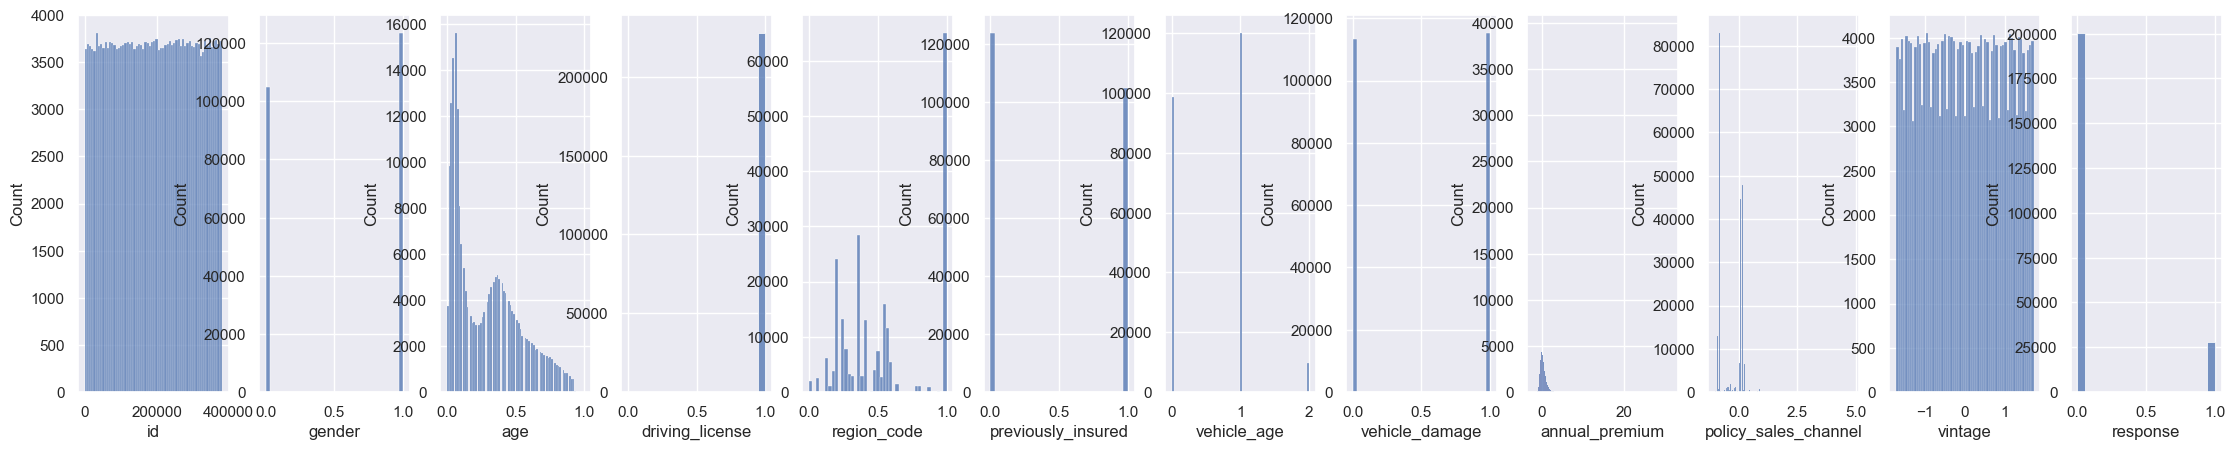

In [48]:
fig = plt.figure(figsize=(30,5))
specs=gridspec.GridSpec(nrows=1, ncols=13, figure=fig)

for n,i in enumerate(df5.select_dtypes(exclude='object').columns):
    ax1= fig.add_subplot(specs[0,n])
    sns.histplot(df5[i],ax=ax1)

##  5.5 target variable transformation

In [49]:
#There's no need to rescale binary target variable

# 6.0 FEATURE SELECTION

In [50]:
df6=df5.copy()
df6=df6.reset_index(drop=True)
ytrain=df6['response']
Xtrain=df6.drop(['response','id'],axis=1)
Xtrain.head(2)

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,1.00000,0.44615,1,0.55221,0,1.00000,1.00000,-0.10504,0.08630,-0.54332
1,0.00000,0.67692,1,0.36014,0,1.00000,1.00000,0.59724,0.08630,1.03467


## 6.1 select K-Best

In [51]:
Xtrain0, Xval, ytrain0, yval = train_test_split(Xtrain,ytrain, test_size=0.25, stratify=ytrain)


In [52]:
Xtrain0, Xval, ytrain0, yval = train_test_split(Xtrain,ytrain, test_size=0.25, stratify=ytrain)


k_vs_score=[]
dic_feat={}
for i in range(3,Xtrain0.shape[1]):
    selector = SelectKBest(score_func=f_classif, k = i)
    Xtrain1 = selector.fit_transform(Xtrain0 , ytrain0)
    Xval1 = selector.transform(Xval)

    mdl= RandomForestClassifier(n_estimators=100, n_jobs=-1 , random_state=42)
    mdl.fit(Xtrain1,ytrain0)


    p = mdl.predict(Xval1)

    score = precision_score(yval, p)
    print( f"k = {i} Precision = {score}")
    k_vs_score.append(score)
    dic_feat[i]=Xtrain0.iloc[:,selector.get_support()].columns

k = 3 Precision = 0.2857142857142857
k = 4 Precision = 0.5294117647058824
k = 5 Precision = 0.2917933130699088
k = 6 Precision = 0.3348566680515164
k = 7 Precision = 0.32576035177720775
k = 8 Precision = 0.3267508610792193
k = 9 Precision = 0.3264692272096252


<AxesSubplot:>

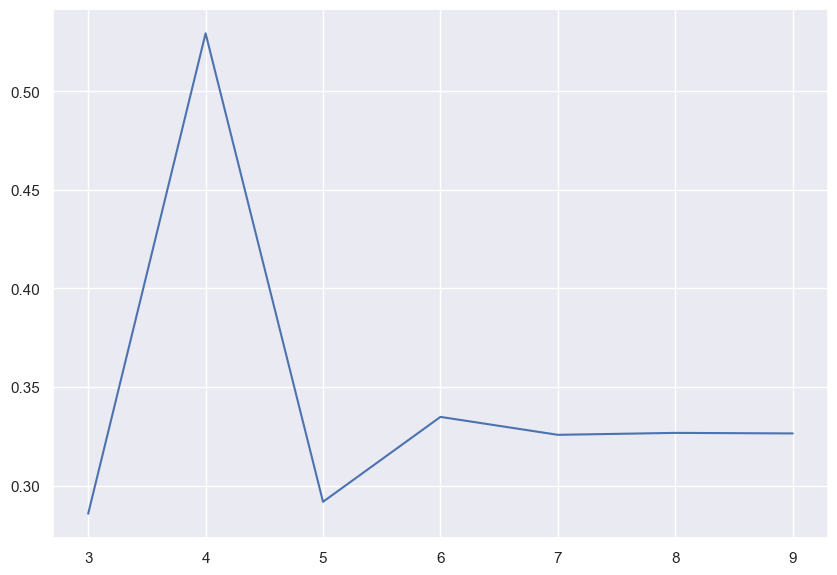

In [53]:
pd.Series(k_vs_score,index = range(3,Xtrain0.shape[1])).plot(figsize=(10,7))

In [54]:
selectorfinal=SelectKBest(score_func=f_classif, k = 6).fit(Xtrain0,ytrain0)
mask0=selectorfinal.get_support()
Xtrain0.columns[mask0]

Index(['age', 'region_code', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'policy_sales_channel'],
      dtype='object')

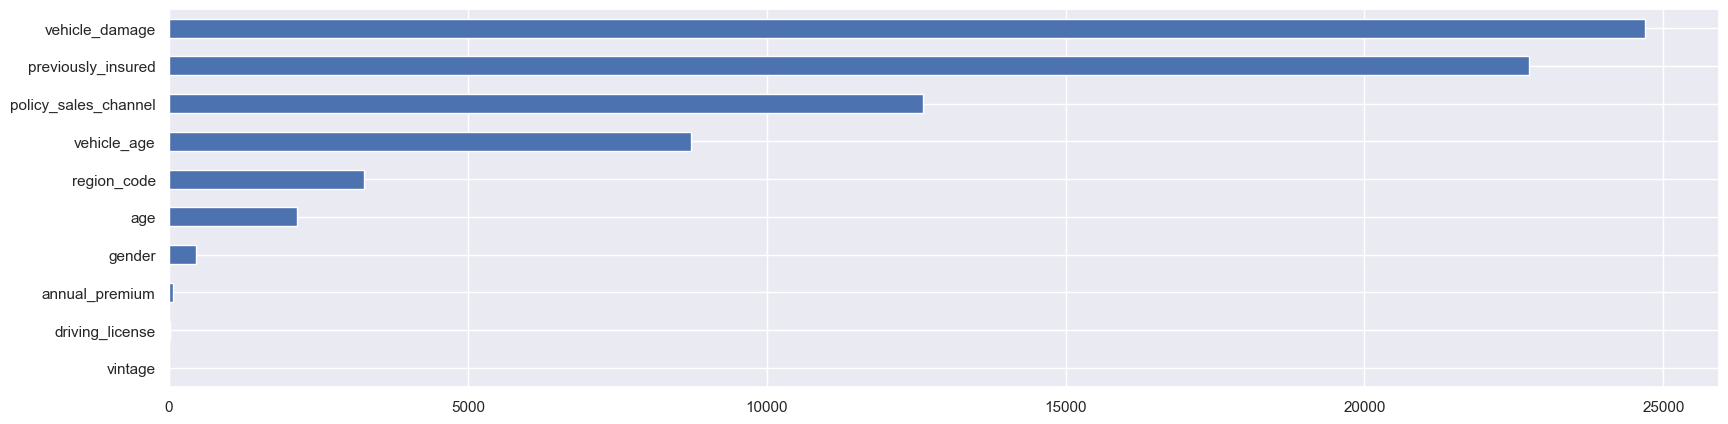

In [55]:
pd.Series(selector.scores_, index=Xtrain.columns).sort_values(ascending=True).plot.barh()
plt.gcf().set_size_inches(20,5)

# 7.0 MACHINE LEARNING MODELLING

In [56]:
Xtrain1=Xtrain[['age', 'region_code', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'policy_sales_channel']]
Xval1=Xval[['age', 'region_code', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'policy_sales_channel']]


## 7.1 Average Model

In [57]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# prediction
pred_random = np.random.choice([0,1],yval.shape[0])

# performance
results_bs = precision_recall_fscore_support(yval,pred_random)
results_bs=pd.DataFrame(results_bs,index=['precision','recall','fscore','support'])
results_bs=results_bs.iloc[:-1,-1].to_frame('metrics').T
results_bs['model']='average'
results_bs

,precision,recall,fscore,model
metrics,0.12225,0.49608,0.19616,average


## 7.2 RandomForestClassifier

In [58]:
rf=RandomForestClassifier(n_estimators=50,random_state=42,n_jobs=-1)
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
precisions = []
recalls = []
fscores = []

for train_index, test_index in skf.split(Xtrain1, ytrain):
    x_train_fold, x_test_fold = Xtrain1.loc[train_index,:], Xtrain1.loc[test_index,:]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    pred=rf.predict(x_test_fold)
    precisions.append(precision_score(y_test_fold,pred))
    recalls.append(recall_score(y_test_fold,pred))
    fscores.append(f1_score(y_test_fold,pred))

dic_results_rf={"precision":precisions,"recall":recalls,"fscore":fscores}
results_rf=pd.DataFrame.from_dict(dic_results_rf)
results_rf=results_rf.mean().to_frame(name='metrics').T
results_rf['model']=rf.__class__.__name__
results_rf

,precision,recall,fscore,model
metrics,0.33662,0.12128,0.17828,RandomForestClassifier


## 7.3 XGBoost Classifier

In [59]:
xb = XGBClassifier(n_estimators=200,random_state=42)
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
precisions = []
recalls = []
fscores = []

for train_index, test_index in skf.split(Xtrain1, ytrain):
    x_train_fold, x_test_fold = Xtrain1.loc[train_index,:], Xtrain1.loc[test_index,:]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    xb.fit(x_train_fold, y_train_fold)
    pred=xb.predict(x_test_fold)
    precisions.append(precision_score(y_test_fold,pred))
    recalls.append(recall_score(y_test_fold,pred))
    fscores.append(f1_score(y_test_fold,pred))


dic_results_xb={"precision":precisions,"recall":recalls,"fscore":fscores}
results_xb=pd.DataFrame.from_dict(dic_results_xb)
results_xb=results_xb.mean().to_frame(name='metrics').T
results_xb['model']=xb.__class__.__name__
results_xb

,precision,recall,fscore,model
metrics,0.41432,0.03201,0.05941,XGBClassifier


## 7.4 LGBMClassifier

In [60]:
lgbm = LGBMClassifier(n_estimators=200,random_state=42,class_weight={1:1,0:0.1})
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
precisions = []
recalls = []
fscores = []

for train_index, test_index in skf.split(Xtrain1, ytrain):
    x_train_fold, x_test_fold = Xtrain1.loc[train_index,:], Xtrain1.loc[test_index,:]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    lgbm.fit(x_train_fold, y_train_fold)
    pred=lgbm.predict(x_test_fold)
    precisions.append(precision_score(y_test_fold,pred))
    recalls.append(recall_score(y_test_fold,pred))
    fscores.append(f1_score(y_test_fold,pred))

dic_results_lgbm={"precision":precisions,"recall":recalls,"fscore":fscores}
results_lgbm=pd.DataFrame.from_dict(dic_results_lgbm)
results_lgbm=results_lgbm.mean().to_frame(name='metrics').T
results_lgbm['model']=lgbm.__class__.__name__
results_lgbm

,precision,recall,fscore,model
metrics,0.27388,0.94634,0.42481,LGBMClassifier


## 7.5 Compare Models Performance

In [64]:
modelling_result=pd.concat([results_bs,results_rf,results_xb,results_lgbm])
modelling_result=modelling_result.add_suffix("_CV_mean")
modelling_result=modelling_result.rename(columns={"model_CV_mean":"model"})
modelling_result=modelling_result[['model','precision_CV_mean', 'recall_CV_mean', 'fscore_CV_mean']]
modelling_result

,model,precision_CV_mean,recall_CV_mean,fscore_CV_mean
metrics,average,0.12225,0.49608,0.19616
metrics,RandomForestClassifier,0.33662,0.12128,0.17828
metrics,XGBClassifier,0.41432,0.03201,0.05941
metrics,LGBMClassifier,0.27388,0.94634,0.42481


# 8.0 HYPERPARAMETER TUNING

In [65]:
params = {
    'max_depth': [25, 50,100,150],
    'num_leaves' : [5,10,15,25,35],
    "min_data_in_leaf": [100,200,300,500,1000],
    "class_weight":[{1:1,0:0.1}],
    "n_jobs":[-1],
    "metric":['f1']
}
lgbm_tuning=LGBMClassifier(random_state=42)

lgbm_random = RandomizedSearchCV(estimator = lgbm_tuning, param_distributions = params,scoring='f1', n_iter = 10, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

lgbm_random.fit(Xtrain1, ytrain)

print(lgbm_random.cv_results_, lgbm_random.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
{'mean_fit_time': array([2.71510983, 2.56319553, 1.94479108, 2.07190788, 3.20302933,
       3.11139441, 2.40272021, 1.96177465, 1.96147621, 2.05147672]), 'std_fit_time': array([0.11368057, 0.13855756, 0.08687909, 0.15560939, 0.2325055 ,
       0.26249612, 0.07401515, 0.1122439 , 0.09970225, 0.1137735 ]), 'mean_score_time': array([0.60350746, 0.58539015, 0.45711833, 0.42551577, 0.94838965,
       0.89459461, 0.63443524, 0.43099076, 0.42372268, 0.42632651]), 'std_score_time': array([0.03748905, 0.02509493, 0.01187667, 0.0262927 , 0.11441714,
       0.0864698 , 0.04515062, 0.03482839, 0.03113462, 0.01473136]), 'param_num_leaves': masked_array(data=[25, 25, 5, 5, 35, 35, 15, 5, 5, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_valu

## 8.1 Final Model

In [66]:
lgbm_random.best_params_

{'num_leaves': 35,
 'n_jobs': -1,
 'min_data_in_leaf': 500,
 'metric': 'f1',
 'max_depth': 50,
 'class_weight': {1: 1, 0: 0.1}}

In [67]:

lgbm_final = lgbm_random.best_estimator_
# prediction
ypredtrain = lgbm_final.predict(Xtrain1)
#ypredtest = lgbm_final.predict(Xtest)


# performance
precision_recall_fscore_support(ytrain,ypredtrain)

(array([0.99115467, 0.27212806]),
 array([0.64169977, 0.95900235]),
 array([0.77903297, 0.42395419]),
 array([200639,  28026], dtype=int64))

In [85]:
pickle.dump(lgbm_final,open(f'parameters/model.pkl','wb'))

In [68]:
Xholdout1=holdout.drop('Response',axis=1)
Xholdout1.columns=Xholdout1.columns.str.lower()
Xholdout1=FeatureEngineering().transform(holdout)
Xholdout1[['vehicle_age',"gender",'vehicle_damage']]=oe.transform(Xholdout1[['vehicle_age','gender','vehicle_damage']])
Xholdout1[['policy_sales_channel','region_code']]=bs.transform(Xholdout1[['policy_sales_channel','region_code']],y=Xholdout1['response'])
Xholdout1=rescaler.transform(Xholdout1)
Xholdout1=Xholdout1[['age', 'region_code', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'policy_sales_channel']].fillna(0)
Xholdout1.head()

p:\Anaconda3\envs\insurance_cross\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
p:\Anaconda3\envs\insurance_cross\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
p:\Anaconda3\envs\insurance_cross\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,age,region_code,previously_insured,vehicle_age,vehicle_damage,policy_sales_channel
192149,0.27692,0.57133,0,1.00000,1.00000,0.15124
189829,0.47692,0.24067,0,1.00000,0.00000,0.23196
373008,0.24615,1.00000,0,1.00000,1.00000,0.15124
266804,0.27692,0.12635,0,1.00000,1.00000,-0.84876
336525,0.47692,0.88360,0,1.00000,1.00000,0.42398


In [69]:
testpred=lgbm_final.predict(Xtrain1)
pd.DataFrame(precision_recall_fscore_support(testpred,ytrain),index=['recall','precision','fscore','support'],columns=[0,1])

,0,1
recall,0.64170,0.95900
precision,0.99115,0.27213
fscore,0.77903,0.42395
support,129899.00000,98766.00000


In [70]:
testpred=lgbm_final.predict(Xholdout1)
pd.DataFrame(precision_recall_fscore_support(testpred,holdout['Response']),index=['recall','precision','fscore','support'],columns=["class 0","class 1"])

,class 0,class 1
recall,0.64054,0.95584
precision,0.99046,0.27083
fscore,0.77796,0.42207
support,86503.00000,65941.00000


# 9.0 BUSINESS PERFORMANCE

## 9.1 How much the model is better than a random guess of whether or not a client will buy an insurance?

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

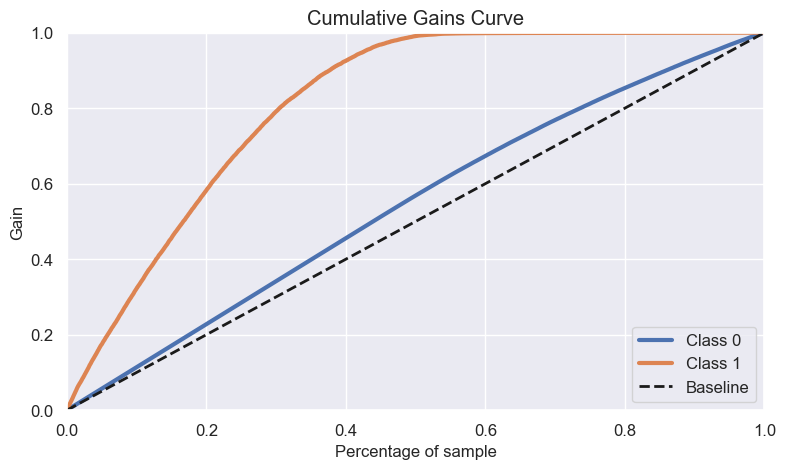

In [71]:
testpred = lgbm_final.predict_proba( Xholdout1 )

skplt.metrics.plot_cumulative_gain( holdout['Response'], testpred , figsize=(9,5))


Text(0.4, 2.3, 'Approximately 2.3 times better than a \n random guess!')

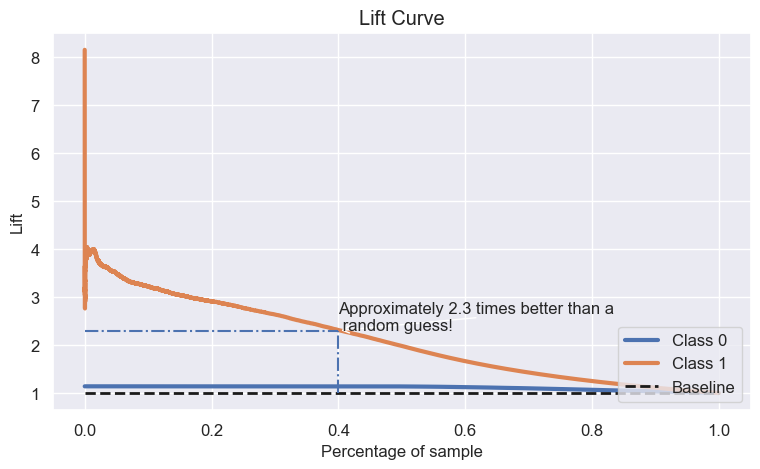

In [72]:

skplt.metrics.plot_lift_curve(holdout['Response'], testpred,figsize=(9,5))
plt.vlines(0.4,1,2.3,linestyles='dashdot')
plt.hlines(2.3,0,0.4,linestyles='dashdot')
plt.annotate("Approximately 2.3 times better than a \n random guess!", (0.4,2.3),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))


## 9.2 How much the model increases the company profit?

In [73]:
sales_cost=250

In [74]:
leads_count=round((holdout.shape[0]*0.4))
print("The amount of leads needed to reach 40% of the clientes base its: ",leads_count)

The amount of leads needed to reach 40% of the clientes base its:  60978


In [75]:
firsts=holdout.iloc[:leads_count,:]
firsts=firsts[firsts['Response']==1]
profit=(firsts['Annual_Premium'].sum()/12)-sales_cost*leads_count
profit

4601077.416666668

In [76]:
print("If the business team would prospectate the first 40% of the entire clients base WITHOUT the model, it would have a profit of: ", "$",profit)

If the business team would prospectate the first 40% of the entire clients base WITHOUT the model, it would have a profit of:  $ 4601077.416666668


In [77]:
holdoutproba=holdout.copy()
holdoutproba['proba']=testpred[:,1]
holdoutproba=holdoutproba.sort_values('proba',ascending=False)
holdoutproba.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,proba
226811,226812,Male,33,1,11.00000,0,< 1 Year,Yes,19444.00000,124.00000,240,0,0.91686
171069,171070,Male,33,1,11.00000,0,< 1 Year,Yes,29220.00000,124.00000,94,1,0.91686
85842,85843,Female,33,1,11.00000,0,< 1 Year,Yes,24771.00000,124.00000,237,1,0.91686
141317,141318,Male,29,1,11.00000,0,< 1 Year,Yes,43801.00000,124.00000,126,0,0.91338
306860,306861,Male,32,1,11.00000,0,< 1 Year,Yes,32518.00000,26.00000,124,1,0.91243


In [78]:
firsts_model=holdoutproba.iloc[:leads_count,:]
firsts_model=firsts_model[firsts_model['Response']==1]
profit_model=(firsts_model['Annual_Premium'].sum()/12)-sales_cost*leads_count
print("If the business team would prospectate the first 40% of the entire clients base USING the model propensity ordering, it would have a profit of: ", "$",profit_model)

If the business team would prospectate the first 40% of the entire clients base USING the model propensity ordering, it would have a profit of:  $ 30787938.75


In [79]:
#Absolute profit increase(Model profit - baseline profit)
print("The absolute profit increase is: $",profit_model-profit)

The absolute profit increase is: $ 26186861.333333332


In [80]:
#Relative profit increase (Model profit - baseline profit)
print("Relative profit increase (Model profit - baseline profit)","{:.0%}".format(profit_model/profit-1))

Relative profit increase (Model profit - baseline profit) 569%


Text(0.5, 0.98, 'Comparison Profit \n without model vs with model')

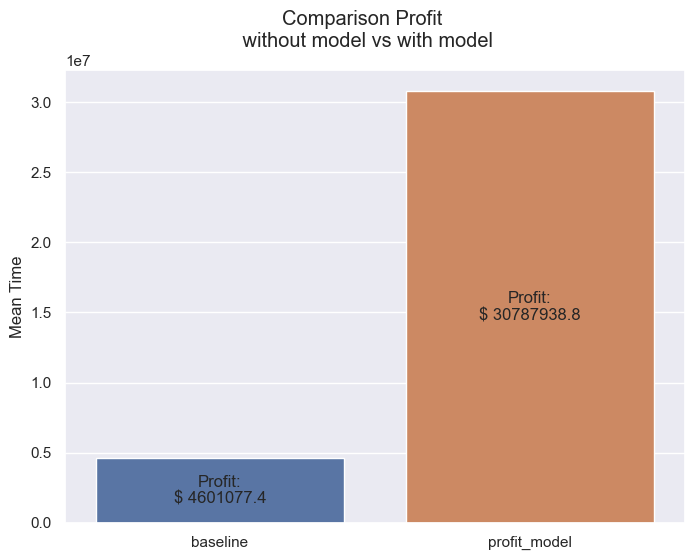

In [83]:
fig, ax = plt.subplots(figsize=(8, 6))

profits=pd.Series([profit,profit_model])
sns.barplot(x=['baseline','profit_model'],y=profits.values,ax=ax)

ax.bar_label(ax.containers[-1], fmt='Profit:\n$ %.1f', label_type='center')

ax.set(ylabel='Mean Time')
plt.suptitle("Comparison Profit \n without model vs with model")


# 10.0 DEPLOY THE MODEL TO PRODUCTION

In [ ]:
Xholdout1=holdout.drop('Response',axis=1)
Xholdout1.columns=Xholdout1.columns.str.lower()
Xholdout1=FeatureEngineering().transform(holdout)
Xholdout1[['vehicle_age',"gender",'vehicle_damage']]=oe.transform(Xholdout1[['vehicle_age','gender','vehicle_damage']])
Xholdout1[['policy_sales_channel','region_code']]=bs.transform(Xholdout1[['policy_sales_channel','region_code']],y=Xholdout1['response'])
Xholdout1=rescaler.transform(Xholdout1)
Xholdout1=Xholdout1[['age', 'region_code', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'policy_sales_channel']].fillna(0)
Xholdout1.head()

## 10.1 Class Insurance

In [98]:
import pickle
import pandas as pd
import numpy as np
import math, datetime

class Insurance( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\insurance_cross'
        self.cleaner = pickle.load( open( self.home_path + r'\parameters\data_cleaning.pkl', 'rb') )
        self.fe = pickle.load( open( self.home_path + r'\parameters\feature_engineering.pkl', 'rb') )
        self.oe = pickle.load( open( self.home_path + r'\parameters\oe.pkl', 'rb') )
        self.be = pickle.load( open( self.home_path + r'\parameters\BayesianEncoding.pkl', 'rb') ) 
        self.model = pickle.load( open( self.home_path + r'\parameters\model.pkl', 'rb') )
        self.rescaler = pickle.load( open( self.home_path + r'\parameters\rescaler.pkl', 'rb') )


        
    def data_cleaning( self, df1 ): 
        
        df1=self.cleaner.transform(df1)

        return df1

    def feature_engineering( self, df2):

        df2=self.fe.transform(df2)

        return df2

        
    def data_preparation( self, df3 ):

        df3=self.oe.transform(df3)
        df3=self.be.transform(df3)
        df3=self.rescaler.transform(df3)
        df3=df3.fillna(0)

        return df3
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

    Insurance()


## 10.2 API Tester

In [114]:
import pickle
import pandas as pd
from flask import Flask, request, Response

# loading model
model = pickle.load( open(r'P:/Python/GitHub/insurance_cross/parameters/model.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( r'/Insurance/predict', methods=['POST'] )
def insurance_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Insurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' ,debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.3.7:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

p:\Anaconda3\envs\insurance_cross\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 10.3 API Tester

In [117]:
xtest=holdout.drop('Response',axis=1)
ytest=holdout['Response']

In [ ]:
# convert Dataframe to json
import json
import requests
data = json.dumps(xtest.to_dict(orient='records'))

In [ ]:
#API Call
url = 'http://192.168.3.7:5000/rossmann/predict'


header = {'Content-type':  'application/json','debug':'True'}

r=requests.post(url, data, headers=header)
print( f'Status Code {r.status_code}')

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())
d1.head()

In [ ]:
precision_recall_fscore_support(d1['prediction'],ytest)